# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2024

Мягкий дедлайн: 22.12.2024 23:59 MSK

Жёсткий дедлайн: 22.12.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Однако с большой силой приходит и большая ответственность, так что заодно научимся, как его правильно готовить

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [2]:
X = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (оставьте `random_state=1337` для воспроизводимости).

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

X_train.shape, X_valid.shape, X_test.shape

((18825, 169), (2354, 169), (2353, 169))

---

## Задание 1. Базовый градиентный бустинг (4 балла)

Первая часть посвящена реализации собственного градиентного бустинга. Обращаем внимание, что пользоваться готовыми реализациями <font color='lightcoral'>**нельзя**</font>, если специально не оговорено. На все <font color='plum'>**вопросы**</font> должен быть <font color='plum'>**ответ**</font>. В заданиях есть референсы для параметров, которые нужно сделать, на случай, если объяснение из ноутбука непонятно, тогда советуем обратиться к соответствующей документации

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

Обязательные параметры:
 — `base_model_class` — класс базовой модели нашего бустинга
 — `base_model_params` — словарь с гиперпараметрами для базовой модели
 — `n_estimators` — какое количество базовых моделей нужно обучить
 — `learning_rate` — темп обучения, должен быть из полуинтервала $(0, 1]$

#### `fit`

В `fit` приходит выборка, на которой мы обучаем новые базовые модели

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на выборке (используем `loss_fn` для этого) и найти новую оптимальную гамму

После всего цикла обучения надо нарисовать график (если `plot=True`).

#### `partial_fit`

В `partial_fit` приходит обучающая выборка, на которую обучается новая базовая модель

#### `predict_proba`

В `predict_proba` приходит любая выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду

#### `plot_history`

В `plot_history` приходит любая выборка, для которой последовательно считаются значения функции потерь и/или любой метрики, которую вы хотите посчитать, путем последовательного применения базовых моделей. Можно делать сразу во время обучения, можно делать иначе

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

from boosting import Boosting

### Проверка кода

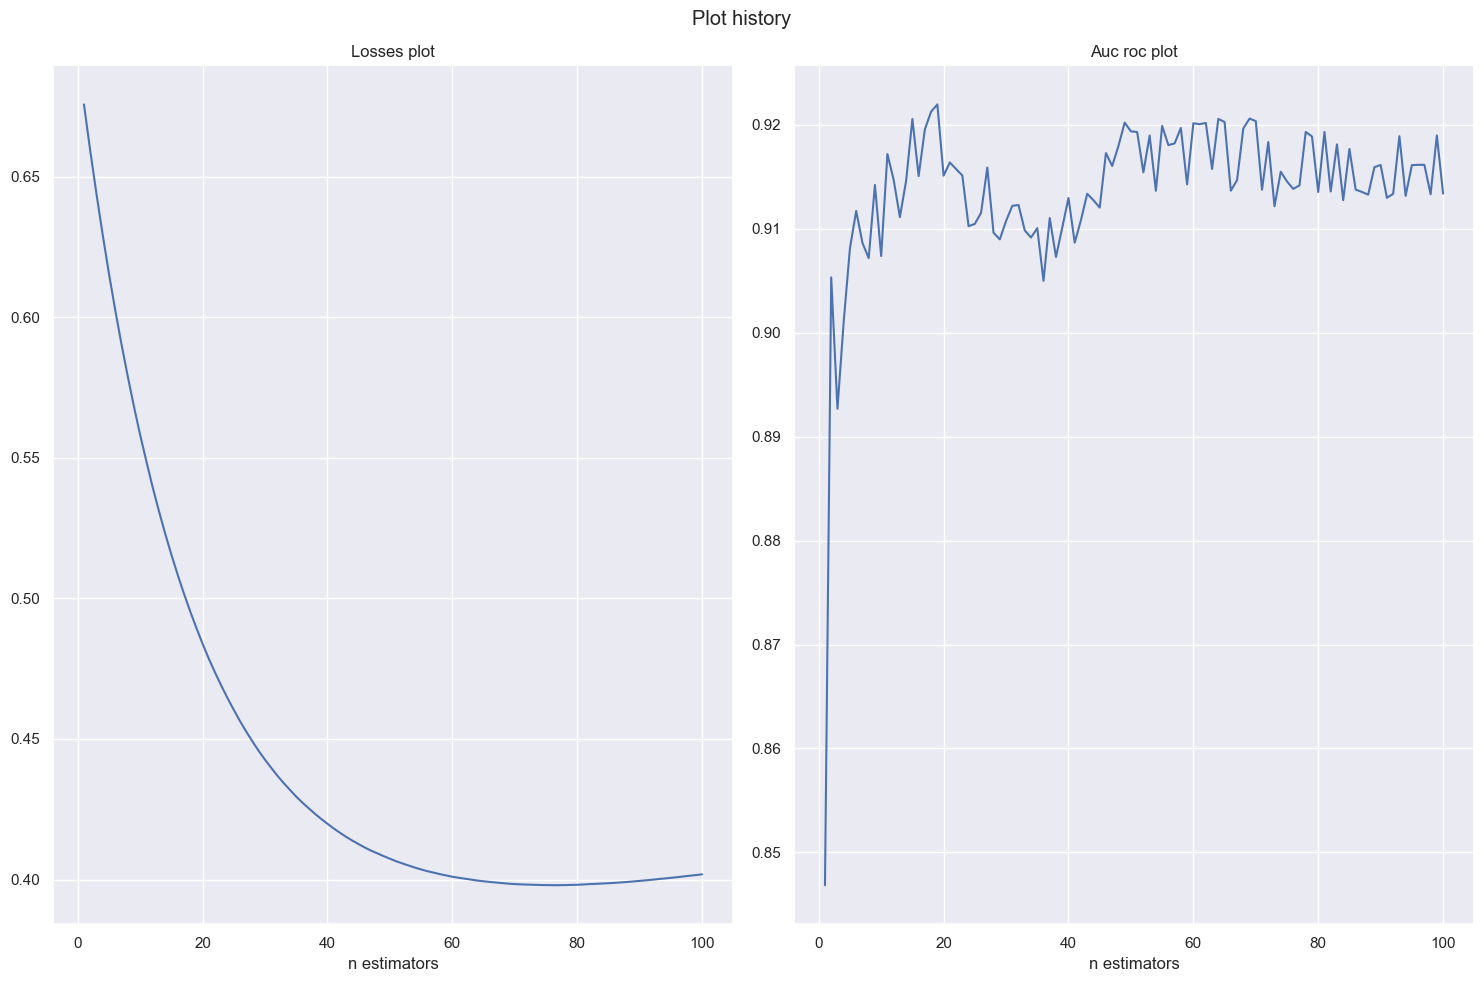

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9134
Test ROC-AUC 0.9108


In [ ]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train)
boosting.plot_history(X_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

---

## Задание 2. Имплементация гиперпараметров (2.5 балла + 3.5 бонус)

Бустинг, как метод агрегации, предлагает несколько вариантов регуляризации безотносительно базовой модели. В этом пункте предлагается имплементировать часть из них. При необходимости можете обратиться к реализациям в вашей любимой библиотеке, там могут быть дополнительные пояснения и/или ссылки на оригинальные статьи

<font color='lightcoral'>**Важно!**</font> После добавления каждого параметра проверьте, как это повлияет на качество. Специально крутить параметры не нужно, но важно увидеть, что перформанс модели изменился, в худшую или в лучшую сторону, для этого какие-то параметры нужны, пусть и от балды, <font color='lightcoral'>**дефолтные параметры не подойдут**</font>, они скорее для референса. Лучше всего это видно по графикам обучения <font color='lightcoral'>**на трейне и валидации**</font>, рекомендуется смотрить именно на них

### 2.1. Борьба с переобучением (0.5 балла)

Как известно, бустинги бывают склонны к переобучению. Чтобы этого не допустить, можно контролировать процесс обучения и проверять критерий останова на валидации. Реализуйте такую процедуру, не забудьте, что всю предобработку, что вы будете делать для трейна, нужно будет повторить на валидации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| <td colspan=3>`early_stopping_rounds`, `eval_set` |

Добавьте параметры:
- `early_stopping_rounds: int | None = 0` — число раундов для критерия останова. Если качество ухудшается на протяжении всех раундов подряд, останавливаем обучение
- `X_val`, `y_val` или `eval_set: Tuple[np.ndarray] | None = None` — валидацонная выборка, на которой будем проверять переобучение

early stopping at iteration 77


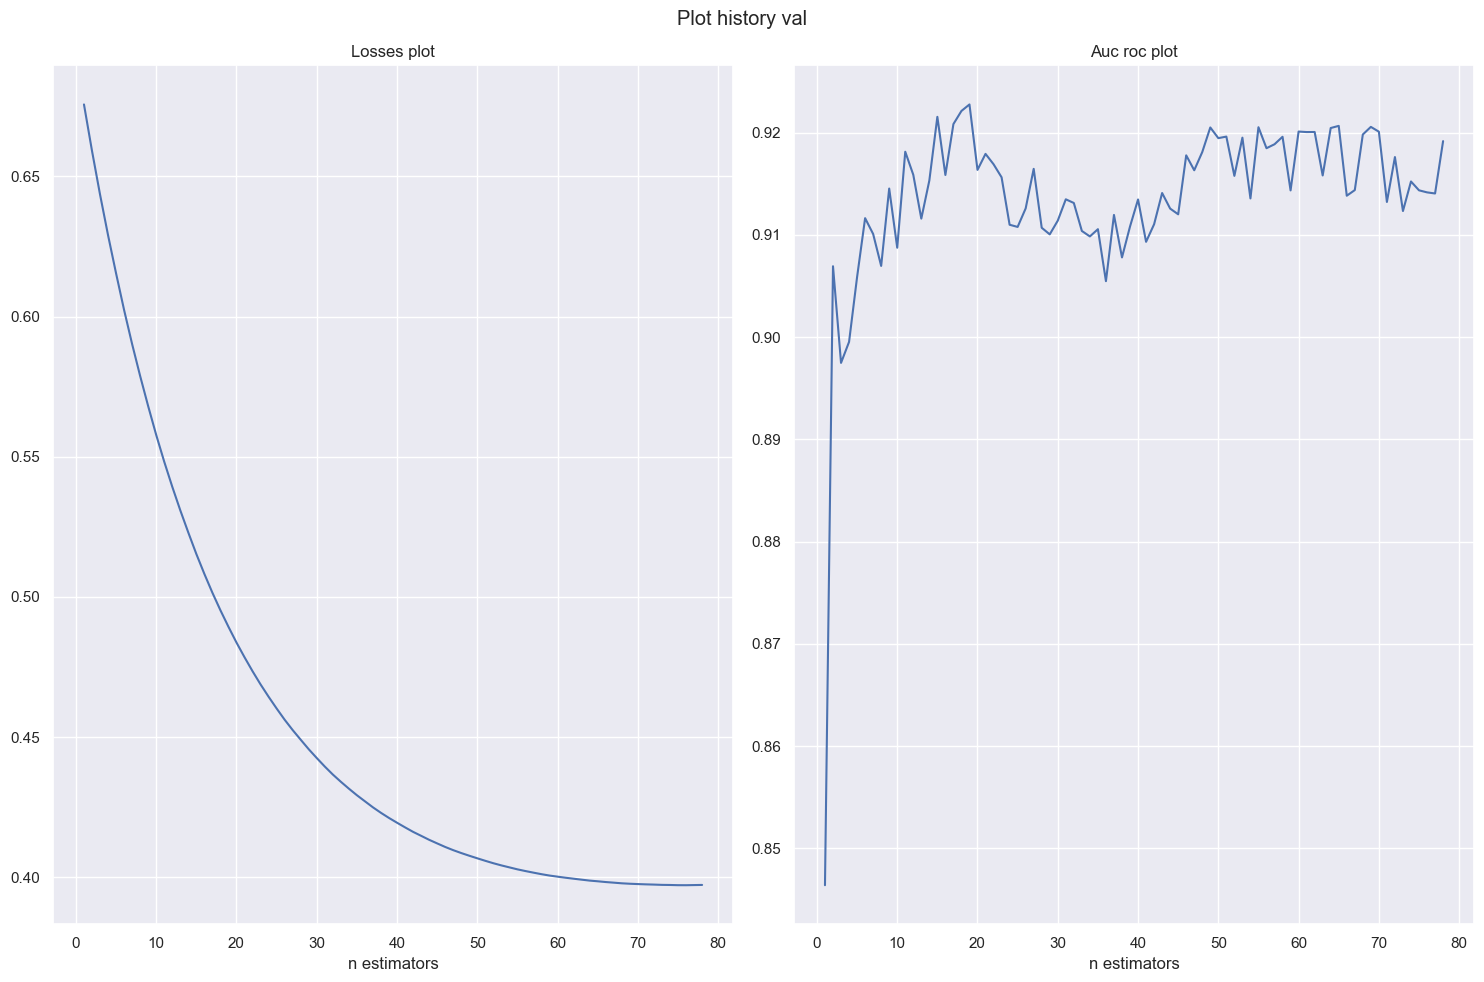

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9192
Test ROC-AUC 0.9151


In [9]:
boosting = Boosting(n_estimators=100, early_stopping_rounds=2)

boosting.fit(X_train, y_train, X_valid, y_valid)
boosting.plot_history(X_valid, y_valid, name='val')

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

__Замечание__: Качество на тесте и валидации выросло, потому что мы как раз и останавливаемся в момент, пока не началось переобучение

### Бонус. Бустинг линейных моделей (0.5 балла)

**<font color='plum'>Вопрос:** что произойдет при ансамблировании линейных моделей? Имеет ли это смысл?</font>

<font color='plum'>**Ответ:** при ансамблировании линейных моделей в итоге получится тоже линейная модель, что эквивалентно одному слою MLP. Такой подход может быть полезен, если выборка близка к линейно разделимой, так как линейные модели почти не переобучаются

Давайте убедимся. Обучите бустинг, где в качестве базовой модели будет линейная регрессия. Обязательно сохраните историю функции потерь и зафиксируйте время обучения. Можно взять уже готовый из <font color='lightblue'>**XGBoost**</font>, но будьте готовы разобраться с тем, как оттуда достать историю обучения

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="gblinear")` | — | — |

In [ ]:
import time
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import boosting as myboost

le = LabelEncoder()

xgb_model = xgb.XGBClassifier(
    booster='gblinear',
    n_estimators=100,
    learning_rate=0.1,
    eval_metric='logloss',
    early_stopping_rounds=10
)

xgb_history = {}

start_time = time.time()

xgb_model.fit(
    X_train,
    le.fit_transform(y_train),
    eval_set=[(X_train, le.transform(y_train)), (X_valid, le.transform(y_valid))],
    verbose=True
)

xgb_time = time.time() - start_time
print(f"Время обучения: {xgb_time:.2f} сек")

xgb_history = xgb_model.evals_result()

print(f'Train ROC-AUC {myboost.score(xgb_model, X_train, y_train):.4f}')
print(f'Valid ROC-AUC {myboost.score(xgb_model, X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {myboost.score(xgb_model, X_test, y_test):.4f}')

[0]	validation_0-logloss:0.55756	validation_1-logloss:0.56045
[1]	validation_0-logloss:0.49718	validation_1-logloss:0.50452
[2]	validation_0-logloss:0.45339	validation_1-logloss:0.46462
[3]	validation_0-logloss:0.42014	validation_1-logloss:0.43491
[4]	validation_0-logloss:0.39400	validation_1-logloss:0.41205
[5]	validation_0-logloss:0.37293	validation_1-logloss:0.39403
[6]	validation_0-logloss:0.35555	validation_1-logloss:0.37954
[7]	validation_0-logloss:0.34101	validation_1-logloss:0.36772
[8]	validation_0-logloss:0.32865	validation_1-logloss:0.35794
[9]	validation_0-logloss:0.31801	validation_1-logloss:0.34975
[10]	validation_0-logloss:0.30876	validation_1-logloss:0.34282
[11]	validation_0-logloss:0.30068	validation_1-logloss:0.33695
[12]	validation_0-logloss:0.29356	validation_1-logloss:0.33194
[13]	validation_0-logloss:0.28724	validation_1-logloss:0.32762
[14]	validation_0-logloss:0.28161	validation_1-logloss:0.32391
[15]	validation_0-logloss:0.27655	validation_1-logloss:0.32068
[1

Теперь возьмите `sklearn.linear_model.SGDClassifier` иобучите на тех же данных. Не забудьте вытащить историю функции потерь

In [34]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

class LossHistory:
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
        self.train_loss = []
        self.val_loss = []
    
    def __call__(self, model, X, y):
        y_train_pred = model.predict_proba(X)
        y_val_pred = model.predict_proba(self.X_val)
        self.train_loss.append(log_loss(y, y_train_pred))
        self.val_loss.append(log_loss(self.y_val, y_val_pred))

sklearn_history = LossHistory(X_valid, le.transform(y_valid))
sklearn_model = SGDClassifier(
    loss='log_loss',
    learning_rate='optimal',
    random_state=42
)

start_time = time.time()

for _ in range(100):
    sklearn_model.partial_fit(X_train, le.transform(y_train), classes=[0, 1])
    sklearn_history(sklearn_model, X_train, le.transform(y_train))

sklearn_time = time.time() - start_time
print(f"Время обучения: {sklearn_time:.2f} сек")

print(f'Train ROC-AUC {myboost.score(sklearn_model, X_train, y_train):.4f}')
print(f'Valid ROC-AUC {myboost.score(sklearn_model, X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {myboost.score(sklearn_model, X_test, y_test):.4f}')

Время обучения: 0.69 сек
Train ROC-AUC 0.9696
Valid ROC-AUC 0.9419
Test ROC-AUC 0.9379


Покажите на одном графике изменение функции потерь для бустинга и SGD классификатора. Сравните следующие детали у бустинга и линейной модели:

- время обучения
- сходимость (как быстро, как стабильно и прочее)
- графики функции потерь на трейне и на валидации

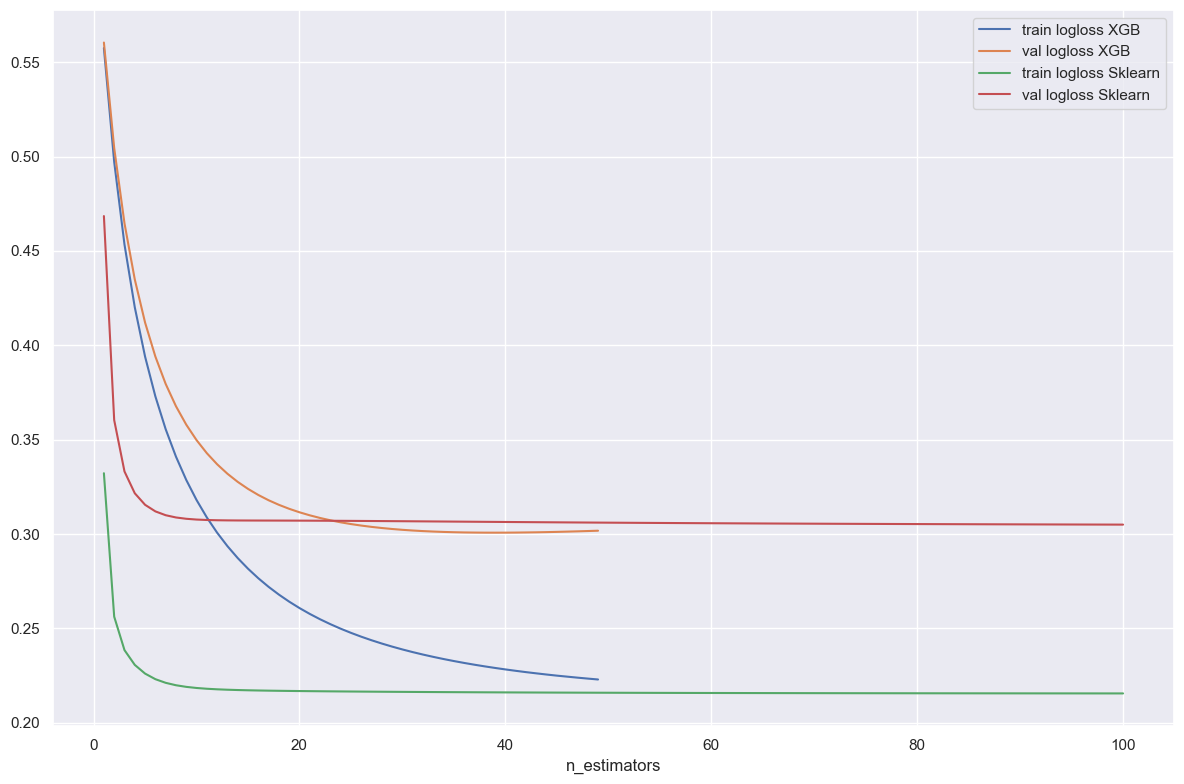

Время обучения XGB: 0.12 сек
Время обучения Sklearn: 0.69 сек


In [39]:
fig, ax = plt.subplots(figsize=(12, 8))

train_losses = xgb_history['validation_0']['logloss']
val_losses = xgb_history['validation_1']['logloss']

ax.plot(range(1, len(train_losses) + 1), train_losses, label='train logloss XGB')
ax.plot(range(1, len(val_losses) + 1), val_losses, label='val logloss XGB')

train_losses = sklearn_history.train_loss
val_losses = sklearn_history.val_loss

ax.plot(range(1, len(train_losses) + 1), train_losses, label='train logloss Sklearn')
ax.plot(range(1, len(val_losses) + 1), val_losses, label='val logloss Sklearn')

ax.set_xlabel('n_estimators')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Время обучения XGB: {xgb_time:.2f} сек")
print(f"Время обучения Sklearn: {sklearn_time:.2f} сек")

<font color='plum'>**Вопрос:** Какой вывод вы можете сделать?</font>

<font color='plum'>**Ответ:** XGB учится заметно быстрее и достигает меньшего лосса на валидации, но при этом целевая метрика на всех подвыборках лучше у SGDClassifier. Также SGDClassifier сходится быстрее

### 2.2. Бутстрап (0.5 балла)
Как известно, при обучении базовых алгоритмов в беггинге, используется бутстрапированная выборка. Звучит хайпово, почему бы не попробовать сделать то же самое в бустинге?

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `subsample`, — | `subsample`, `bagging`| `subsample`, `bootstrap_type`|

Вам нужно реализовать параметры:
- `subsample: float | int = 1.0` — доля или число объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей). Соответствует бутстрапу типа `Bernoulli`. Каждый объект либо входит в подвыборку, либо нет
- `bagging_temperature: float | int = 1.0` — веса объектов, которые попадают в выборку. Соответствует бутстрапу типа `Bayesian`. Каждый объект имеет определенный вес $t$, на который впоследствии домножается по формуле $w = (-\log(X))^t$, где $X \sim {U[0, 1]}$, после чего попадает в выборку. Таким образом можно сделать симуляцию повторений
- `bootstrap_type: str | None = 'Bernoulli'` — тип бутстрапа

<font color='plum'>**Вопрос:** как бутстрап может помочь в обучении с точки зрения смещения, разброса и вообще?</font>

<font color='plum'>**Ответ:** бутстрап делает модели в композиции более независимыми, а также не позволяет переобучатсья, поэтому разброс композиции падает. Однако смещение каждой базовой модели может незначительно увеличиться, но такое поведение как раз очень полезно для бустинга, так как он не влияет на разброс, но уменьшает смещение с ростом числа моделей

early stopping at iteration 77


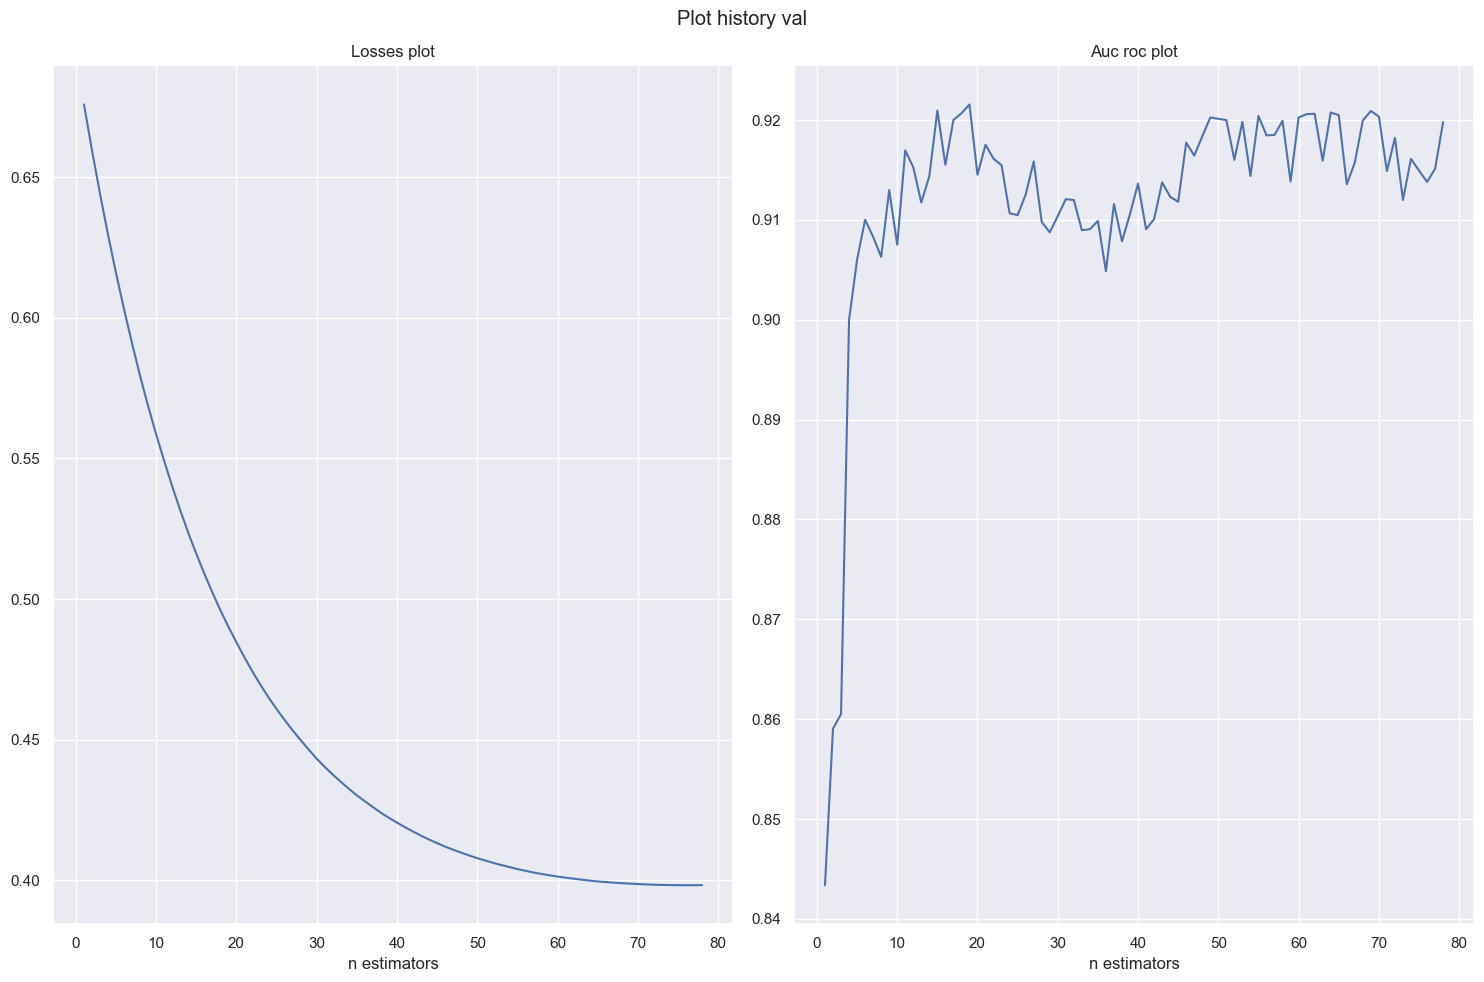

Время обучения: 10.90 сек
Train ROC-AUC 0.9998
Valid ROC-AUC 0.9198
Test ROC-AUC 0.9158


In [10]:
start_time = time.time()

boosting = Boosting(n_estimators=100, early_stopping_rounds=2, 
                    bootstrap_type='Bernouli', subsample=0.8)

boosting.fit(X_train, y_train, X_valid, y_valid)
boosting.plot_history(X_valid, y_valid, name='val')

trainig_time = time.time() - start_time
print(f"Время обучения: {trainig_time:.2f} сек")

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

early stopping at iteration 111


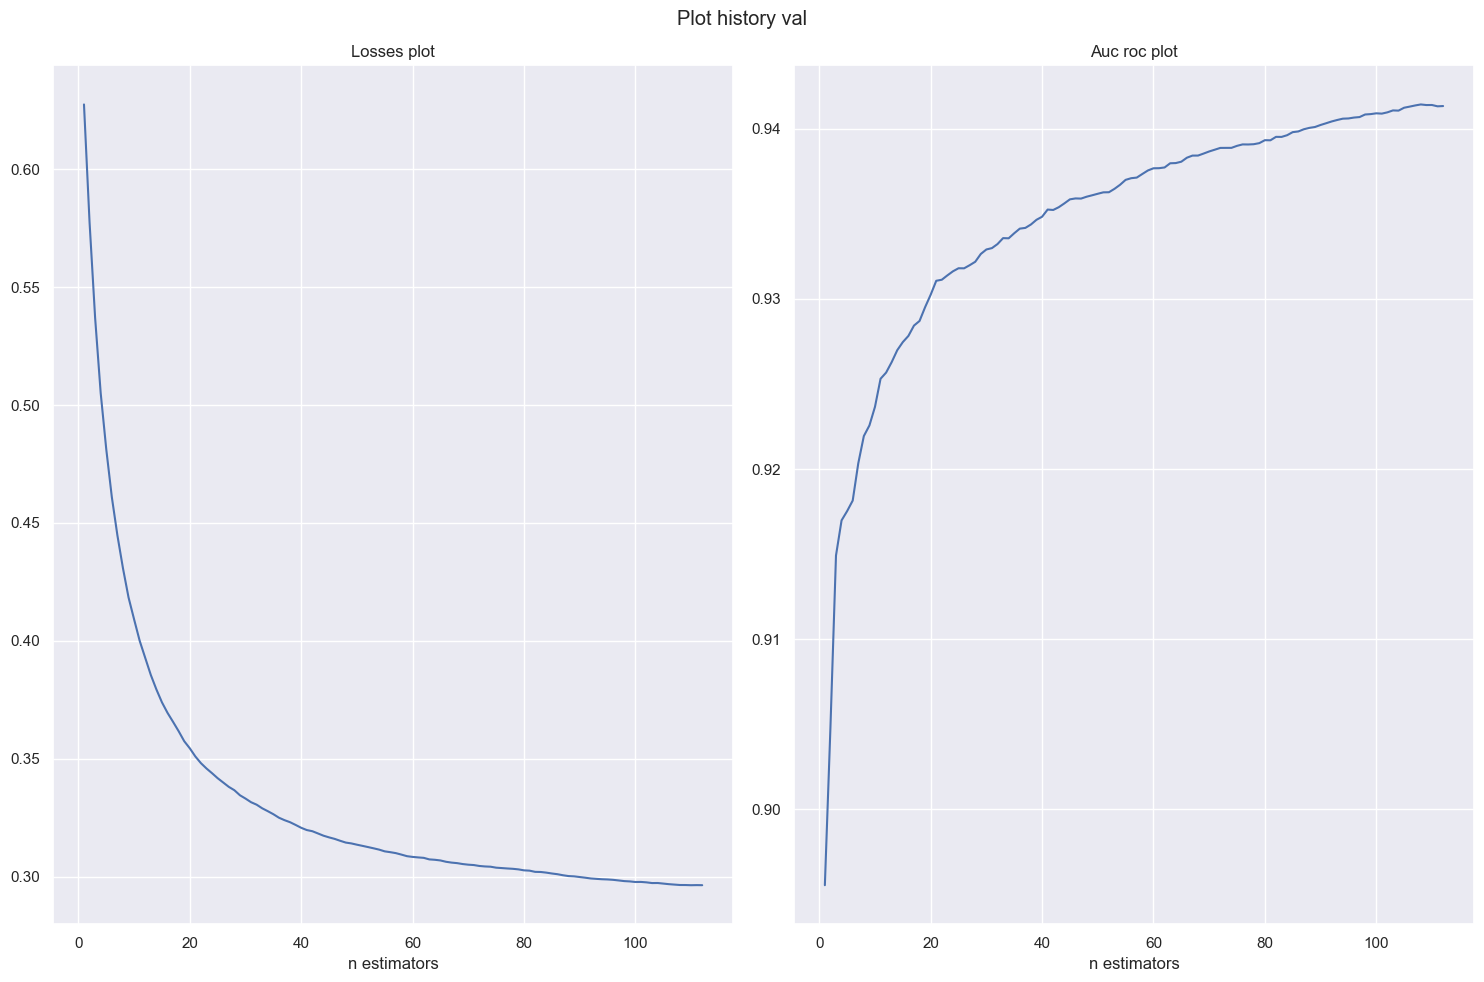

Время обучения: 4.63 сек
Train ROC-AUC 0.9702
Valid ROC-AUC 0.9413
Test ROC-AUC 0.9373


In [21]:
start_time = time.time()

boosting = Boosting(base_model_params={'max_depth': 3}, n_estimators=200, early_stopping_rounds=2, 
                    bootstrap_type='Bayesian', bagging_temperature=1.0, learning_rate=0.5)

boosting.fit(X_train, y_train, X_valid, y_valid)
boosting.plot_history(X_valid, y_valid, name='val')

trainig_time = time.time() - start_time
print(f"Время обучения: {trainig_time:.2f} сек")

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

early stopping at iteration 118


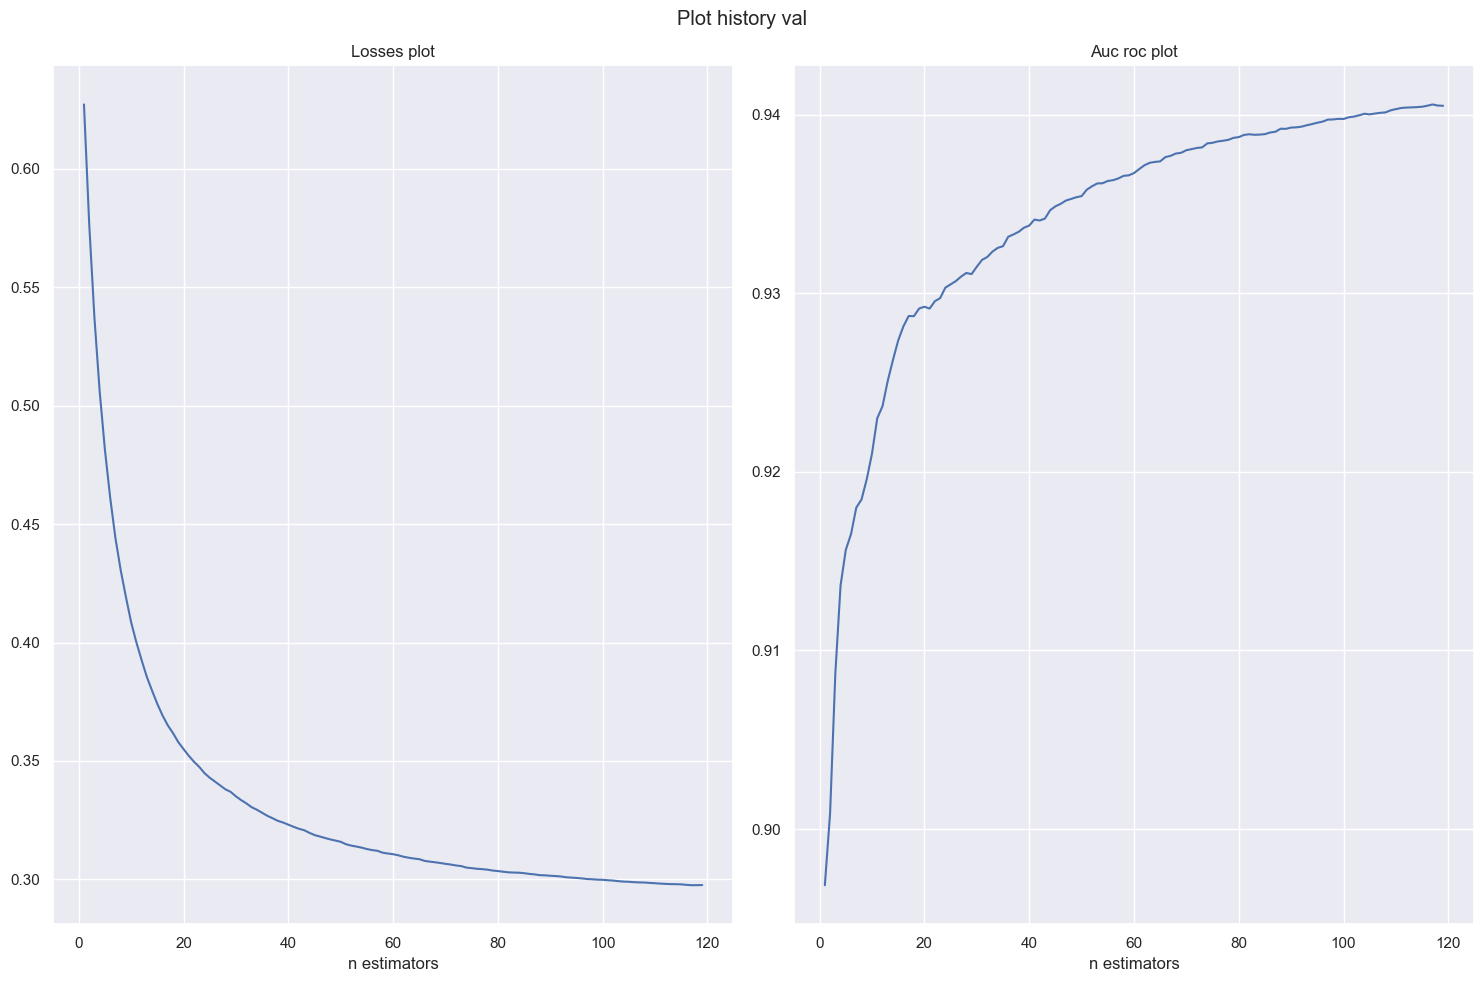

Время обучения: 4.69 сек
Train ROC-AUC 0.9700
Valid ROC-AUC 0.9405
Test ROC-AUC 0.9362


In [23]:
start_time = time.time()

boosting = Boosting(base_model_params={'max_depth': 3}, n_estimators=200, early_stopping_rounds=2 ,learning_rate=0.5)

boosting.fit(X_train, y_train, X_valid, y_valid)
boosting.plot_history(X_valid, y_valid, name='val')

trainig_time = time.time() - start_time
print(f"Время обучения: {trainig_time:.2f} сек")

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### 2.3. Работа с признаками (1 балл)

1. Помимо выбора случайных объектов, есть идея выбирать случайное подмножество признаков, заложенная в Random Forest. Мотивация это делать точно та же самая, что и в бутстрапировании, за это будет отвечать `rsm`

2. С другой стороны, вместо того, чтобы выкидывать признаки, можно попробовать проредить их множество значений, применив бинаризацию. В идеале это стоит делать с датасетом до обучения модели, но не обязательно, можно, например, на этапе `fit`, а в `partial_fit` приходит уже квантизованный датасет. Для этого существует множество алгоритмов, мы предлагаем сделать два наиболее простых:

- $\text{Uniform}$. Значения признака $[\min f_i, \max f_i]$ отображаются в `nbins` отрезков одинаковой длины, которые полностью покрывают интервал
- $\text{Quantile}$. Тот же самый отрезок сортируется и бьется на `nbins` квантилей от 0 до 1

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `colsample_bytree`, `tree_method` | `colsample_bytree`, `max_bin`| `rsm`, `quantize(...)`|

Нужно добавить параметры:
- `rsm: float | int = 1.0` — доля или число признаков, участвующих в обучении модели. Каждый признак либо входит, либо не входит в пул, на котором обучается базовый алгоритм, по аналогии с бутстрапом Бернулли
- `quantization_type: str | None = None` — тип квантизации, если она есть
- `nbins: int = 255` — число бинов для квантизации. Игнорируем, если тип квантизации не указан

<font color='plum'>**Вопрос**: как квантизация поможет в обработке выбросов и нанов?</font>

<font color='plum'>**Ответ**: выбросы и наны попадут в отдельные от остальных данных бины, что позволит модели адекватно их обработать безотносительно значений признаков, если это выбросы

<font color='plum'>**Вопрос**: можно ли просто заполнить наны каким-то числом? Имеет ли значение, что это за число (-1, -100, -1e32)?</font>

<font color='plum'>**Ответ**: не всегда, но в некоторых ситуациях возможно. Например, если известно, что используем бинаризацию, то имеет смысл заменить наны на число, которое больше или меньше всех остальных, чтобы они всегда попадали в одну и ту же категорию

### 2.4. Важность признаков (0.5 балла)

Поскольку наша базовая модель — это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными — иначе вы что-то сделали не так). Разумеется, способ не единственный, если хочется, посмотрите в документации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `model.get_score()` | `lightgbm.importance()` | `model.get_feature_importance()` |

Допишите к бустингу:
- `feature_importances_` — атрибут, который возвращает важность признаков, согласно методу выше

In [110]:
start_time = time.time()

boosting = Boosting(base_model_params={'max_depth': 3}, n_estimators=200, early_stopping_rounds=2 ,learning_rate=0.5, subsample=0.8, bootstrap_type='Bernoulli')
boosting.fit(X_train, y_train, X_valid, y_valid)

trainig_time = time.time() - start_time
print(f"Время обучения: {trainig_time:.2f} сек")

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

early stopping at iteration 109
Время обучения: 3.62 сек
Train ROC-AUC 0.9701
Valid ROC-AUC 0.9401
Test ROC-AUC 0.9387


Покажите, какие признаки оказались самыми важными

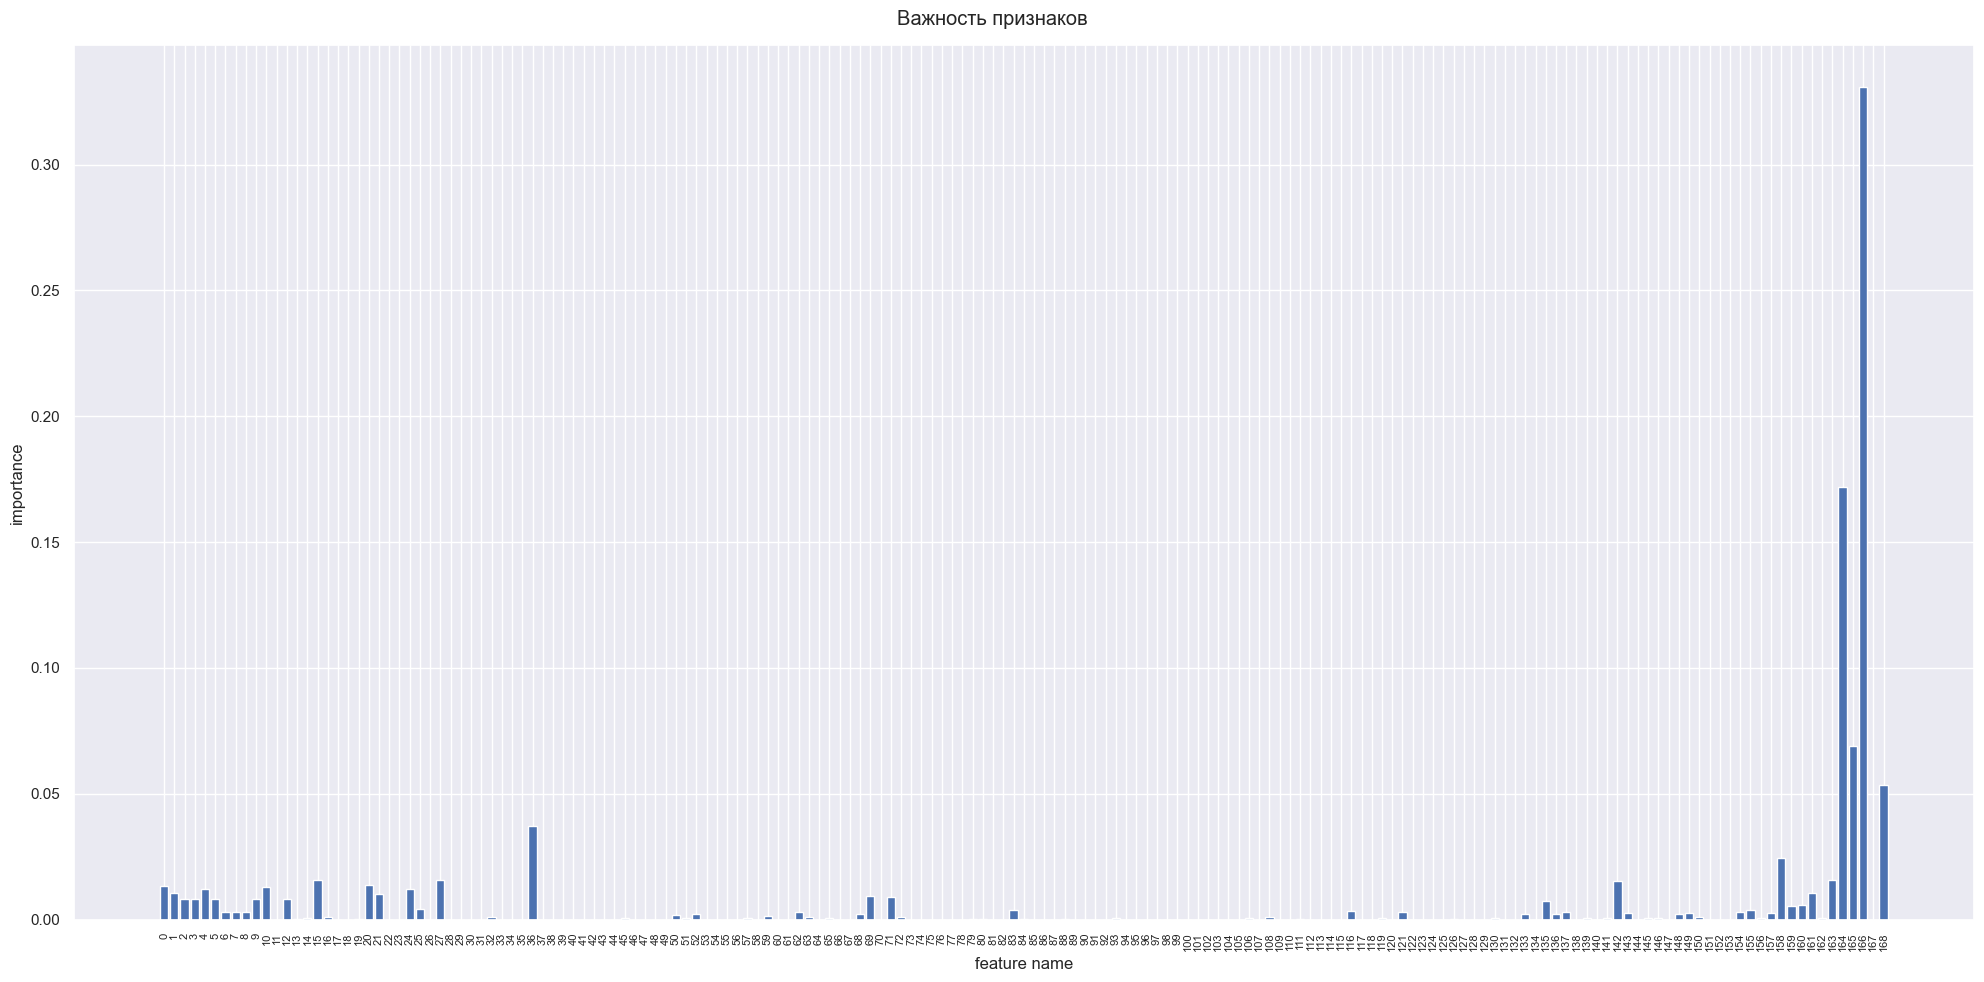

In [118]:
feature_importances = boosting.feature_importances_

fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(range(X_train.shape[1]), feature_importances)
labels = [f'{i}' for i in range(X_train.shape[1])]
ax.set_xticks(ticks=range(X.shape[1]), labels=labels, rotation=90, fontsize=8)
ax.set_xlabel('feature name')
ax.set_ylabel('importance')
fig.suptitle('Важность признаков')
plt.tight_layout()
plt.show()

------

## Задание 3. Оптимизация (3.5 балла + 0.5 бонус)

Теперь давайте подумаем, как же правильно применять бустинги. Нас интересует: какие бустинги вообще бывают, как их правильно тюнить, и как интерпретировать

Оптимизация моделей с большим числом гиперпараметров это сложное дело. Нетрудно догадаться, что в случае, когда параметров $m$, сложность перебора в самом худшем случае будет порядка $n^m$. У бустингов, хотя на самом деле не только, эта проблема стоит особенно остро. Подумаем, как это делать умнее

### 3.1. Знакомство с optuna (1 балл)

Для эффективного подбора гиперпараметров существует несколько решений, основанных на байесовской оптимизации. В этом задании предлагается познакомиться с библиотекой [optuna](https://optuna.org/), которая делает перебор гиперпараметров легким и приятным, а также сохраняет всю историю экспериментов в одно место за вас

Подберите на валидации оптимальные значения следующих гиперпараметров для вашей реализации бустинга:
- `max_depth`
- `n_estimators`
- `learning_rate`
- любые другие параметры, которые вам понравились

Заметим, что оптуна это крайне гибкая библиотека, в которой можно реализовать абсолютно любую логику, которую пожелаете. За вас там есть лишь выбор модели. Чтобы не плодить несколько `objective`, можно слегка менять тело функции, например, добавить опциональные параметры, но шаблоном пользоваться не обязательно, как обычно

Подберите диапазон параметров самостоятельно, не забывайте фиксировать сид (нет, его не нужно перебирать). Сохраните и покажите оптимальный набор параметров. Сравните графики функций потерь для оптимального и дефолтного бустингов. Покажите, какие параметры дали наибольший прирост (для этого придется почитать документацию оптуны)

In [ ]:
import optuna

SEED = 42
np.random.seed(SEED)

def objective(trial):
    base_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }

    boosting_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'early_stopping_rounds': 5,
        'bootstrap_type': 'Bernoulli',
        'base_model_params': base_params
    }

    model = Boosting(**boosting_params)
    model.fit(X_train, y_train, X_valid, y_valid)

    return myboost.score(model, X_valid, y_valid)

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-04-08 00:43:43,308] A new study created in memory with name: no-name-2d3c3772-9f0e-4344-93b2-5973cc38c134
[I 2025-04-08 00:44:02,285] Trial 4 finished with value: 0.9405567222447047 and parameters: {'max_depth': 8, 'n_estimators': 123, 'learning_rate': 0.0945086150657385, 'subsample': 0.5700026062173265}. Best is trial 4 with value: 0.9405567222447047.
[I 2025-04-08 00:44:07,230] Trial 0 finished with value: 0.9338658863551645 and parameters: {'max_depth': 6, 'n_estimators': 157, 'learning_rate': 0.010011278992501088, 'subsample': 0.8352378713645601}. Best is trial 4 with value: 0.9405567222447047.
[I 2025-04-08 00:44:14,015] Trial 8 finished with value: 0.9291194436928146 and parameters: {'max_depth': 5, 'n_estimators': 75, 'learning_rate': 0.010818718939853896, 'subsample': 0.99131459832882}. Best is trial 4 with value: 0.9405567222447047.
[I 2025-04-08 00:44:23,174] Trial 1 finished with value: 0.9363542467351993 and parameters: {'max_depth': 3, 'n_estimators': 270, 'learnin

early stopping at iteration 128


[I 2025-04-08 00:44:49,684] Trial 5 finished with value: 0.9413066226703799 and parameters: {'max_depth': 9, 'n_estimators': 381, 'learning_rate': 0.026627988398087717, 'subsample': 0.8982292967039968}. Best is trial 10 with value: 0.9418394151495052.
[I 2025-04-08 00:44:52,341] Trial 6 finished with value: 0.9388242487226949 and parameters: {'max_depth': 3, 'n_estimators': 470, 'learning_rate': 0.07726492485807061, 'subsample': 0.6166454327449734}. Best is trial 10 with value: 0.9418394151495052.
[I 2025-04-08 00:44:53,948] Trial 9 finished with value: 0.9411557645751667 and parameters: {'max_depth': 4, 'n_estimators': 315, 'learning_rate': 0.10323933043781199, 'subsample': 0.5201090625734988}. Best is trial 10 with value: 0.9418394151495052.
[I 2025-04-08 00:44:56,943] Trial 2 finished with value: 0.932283871832878 and parameters: {'max_depth': 3, 'n_estimators': 484, 'learning_rate': 0.03076165385231836, 'subsample': 0.997751078730738}. Best is trial 10 with value: 0.941839415149505

early stopping at iteration 91


[I 2025-04-08 00:45:15,049] Trial 18 finished with value: 0.9404377917886901 and parameters: {'max_depth': 10, 'n_estimators': 386, 'learning_rate': 0.2290852524675319, 'subsample': 0.8434799266048111}. Best is trial 10 with value: 0.9418394151495052.


early stopping at iteration 99


[I 2025-04-08 00:45:18,691] Trial 20 finished with value: 0.9394476358780459 and parameters: {'max_depth': 10, 'n_estimators': 398, 'learning_rate': 0.2859007030591506, 'subsample': 0.8882602681932666}. Best is trial 10 with value: 0.9418394151495052.


early stopping at iteration 80


[I 2025-04-08 00:45:19,611] Trial 19 finished with value: 0.939060114157274 and parameters: {'max_depth': 10, 'n_estimators': 392, 'learning_rate': 0.23941258873264434, 'subsample': 0.8656385740364309}. Best is trial 10 with value: 0.9418394151495052.


early stopping at iteration 91


[I 2025-04-08 00:45:21,259] Trial 16 finished with value: 0.9435375664593766 and parameters: {'max_depth': 7, 'n_estimators': 182, 'learning_rate': 0.1446067346754084, 'subsample': 0.5760797804584294}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:45:23,500] Trial 15 finished with value: 0.9323161985675663 and parameters: {'max_depth': 5, 'n_estimators': 211, 'learning_rate': 0.015366211832165853, 'subsample': 0.9932851942510355}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:45:28,045] Trial 21 finished with value: 0.9390736834039333 and parameters: {'max_depth': 10, 'n_estimators': 392, 'learning_rate': 0.2905764260170243, 'subsample': 0.8984981695814558}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 94
early stopping at iteration 346


[I 2025-04-08 00:45:30,727] Trial 12 finished with value: 0.9424727796921057 and parameters: {'max_depth': 9, 'n_estimators': 368, 'learning_rate': 0.06304269442656277, 'subsample': 0.8239032840712031}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 410


[I 2025-04-08 00:45:40,618] Trial 14 finished with value: 0.9427645184952824 and parameters: {'max_depth': 7, 'n_estimators': 431, 'learning_rate': 0.06336557834140098, 'subsample': 0.5002081049077902}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:45:42,515] Trial 27 finished with value: 0.9409821580370248 and parameters: {'max_depth': 7, 'n_estimators': 84, 'learning_rate': 0.16124053415875844, 'subsample': 0.7254942454690252}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:45:45,132] Trial 23 finished with value: 0.9431755868499633 and parameters: {'max_depth': 8, 'n_estimators': 408, 'learning_rate': 0.16910995014664243, 'subsample': 0.9111781988365639}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 143


[I 2025-04-08 00:45:45,718] Trial 22 finished with value: 0.9419870804807983 and parameters: {'max_depth': 8, 'n_estimators': 409, 'learning_rate': 0.15679812788795727, 'subsample': 0.9054666240890431}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 167


[I 2025-04-08 00:45:47,309] Trial 25 finished with value: 0.9411773157316259 and parameters: {'max_depth': 8, 'n_estimators': 214, 'learning_rate': 0.15897023261695745, 'subsample': 0.7439408991930425}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 147


[I 2025-04-08 00:45:53,428] Trial 24 finished with value: 0.9427892624156611 and parameters: {'max_depth': 8, 'n_estimators': 418, 'learning_rate': 0.15017059306351713, 'subsample': 0.9139473540815178}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 185


[I 2025-04-08 00:45:58,898] Trial 26 finished with value: 0.9428599023173879 and parameters: {'max_depth': 7, 'n_estimators': 231, 'learning_rate': 0.15522320161094227, 'subsample': 0.7373376533517431}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 208


[I 2025-04-08 00:46:03,090] Trial 28 finished with value: 0.9421355440030715 and parameters: {'max_depth': 7, 'n_estimators': 432, 'learning_rate': 0.14685387463613525, 'subsample': 0.7423228436973606}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 191


[I 2025-04-08 00:46:12,689] Trial 29 finished with value: 0.9434972578148884 and parameters: {'max_depth': 7, 'n_estimators': 338, 'learning_rate': 0.13989382588511706, 'subsample': 0.7335352830989015}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 192


[I 2025-04-08 00:46:20,017] Trial 31 finished with value: 0.9423287062202226 and parameters: {'max_depth': 6, 'n_estimators': 431, 'learning_rate': 0.14426470278817008, 'subsample': 0.5784706619767083}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 227


[I 2025-04-08 00:46:25,776] Trial 36 finished with value: 0.9416035497149261 and parameters: {'max_depth': 6, 'n_estimators': 142, 'learning_rate': 0.11524124418579021, 'subsample': 0.7872653650139917}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:46:26,476] Trial 34 finished with value: 0.9425003172809147 and parameters: {'max_depth': 7, 'n_estimators': 500, 'learning_rate': 0.13201773776305717, 'subsample': 0.9444057788934879}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 194


[I 2025-04-08 00:46:29,573] Trial 35 finished with value: 0.9384710492140613 and parameters: {'max_depth': 6, 'n_estimators': 193, 'learning_rate': 0.04271437132719874, 'subsample': 0.7874374857119602}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:46:34,566] Trial 30 finished with value: 0.9419659284198292 and parameters: {'max_depth': 7, 'n_estimators': 332, 'learning_rate': 0.046919700672942447, 'subsample': 0.5703930638503296}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:46:50,554] Trial 41 finished with value: 0.9429469051342039 and parameters: {'max_depth': 7, 'n_estimators': 241, 'learning_rate': 0.19220312514667512, 'subsample': 0.6954551314865122}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 140


[I 2025-04-08 00:46:53,359] Trial 32 finished with value: 0.9427828768878215 and parameters: {'max_depth': 7, 'n_estimators': 442, 'learning_rate': 0.045635157552146845, 'subsample': 0.5632272008350263}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:46:55,662] Trial 37 finished with value: 0.9429536897575336 and parameters: {'max_depth': 6, 'n_estimators': 327, 'learning_rate': 0.11661870118464454, 'subsample': 0.6786491819404085}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 285


[I 2025-04-08 00:46:55,696] Trial 33 finished with value: 0.9431484483566445 and parameters: {'max_depth': 7, 'n_estimators': 448, 'learning_rate': 0.04419842008069931, 'subsample': 0.5700192562130888}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:47:01,510] Trial 38 finished with value: 0.9431065433301964 and parameters: {'max_depth': 6, 'n_estimators': 337, 'learning_rate': 0.1072013059230775, 'subsample': 0.792939494260592}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 268


[I 2025-04-08 00:47:02,309] Trial 39 finished with value: 0.9408464655704312 and parameters: {'max_depth': 7, 'n_estimators': 237, 'learning_rate': 0.042278193174978544, 'subsample': 0.6903594899987996}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:47:03,571] Trial 40 finished with value: 0.9402330558023295 and parameters: {'max_depth': 6, 'n_estimators': 243, 'learning_rate': 0.04659613633539006, 'subsample': 0.6886169125265627}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:47:11,947] Trial 42 finished with value: 0.9419028713324121 and parameters: {'max_depth': 6, 'n_estimators': 243, 'learning_rate': 0.08007383499044499, 'subsample': 0.6945198987249245}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:47:13,082] Trial 43 finished with value: 0.9419747085206089 and parameters: {'max_depth': 8, 'n_estimators': 306, 'learning_rate': 0.19339318000659864, 'subsample': 0.6749066863362447}. Best is trial 16 with value: 0.943537566

early stopping at iteration 135


[I 2025-04-08 00:47:15,560] Trial 44 finished with value: 0.9424081262227288 and parameters: {'max_depth': 8, 'n_estimators': 299, 'learning_rate': 0.2083188232844972, 'subsample': 0.7009784058534941}. Best is trial 16 with value: 0.9435375664593766.


early stopping at iteration 139


[I 2025-04-08 00:47:28,773] Trial 45 finished with value: 0.9426910849251257 and parameters: {'max_depth': 6, 'n_estimators': 297, 'learning_rate': 0.08395622663946346, 'subsample': 0.6510494679703309}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:47:29,935] Trial 46 finished with value: 0.9425326440156032 and parameters: {'max_depth': 8, 'n_estimators': 294, 'learning_rate': 0.08535280215583134, 'subsample': 0.6251238214233719}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:47:31,557] Trial 47 finished with value: 0.9434545545974604 and parameters: {'max_depth': 8, 'n_estimators': 285, 'learning_rate': 0.07560406645816396, 'subsample': 0.6103427609137814}. Best is trial 16 with value: 0.9435375664593766.
[I 2025-04-08 00:47:32,149] Trial 49 finished with value: 0.9427661148772422 and parameters: {'max_depth': 8, 'n_estimators': 285, 'learning_rate': 0.07788779871287209, 'subsample': 0.6028488809184852}. Best is trial 16 with value: 0.9435375664

Лучшие параметры: {'max_depth': 7, 'n_estimators': 182, 'learning_rate': 0.1446067346754084, 'subsample': 0.5760797804584294}


In [124]:
print("Лучшие параметры:", study.best_params)
print(f"Лучший ROC AUC: {study.best_trial.value}")
optuna.visualization.plot_param_importances(study)

Лучшие параметры: {'max_depth': 7, 'n_estimators': 182, 'learning_rate': 0.1446067346754084, 'subsample': 0.5760797804584294}
Лучший ROC AUC: 0.9435375664593766


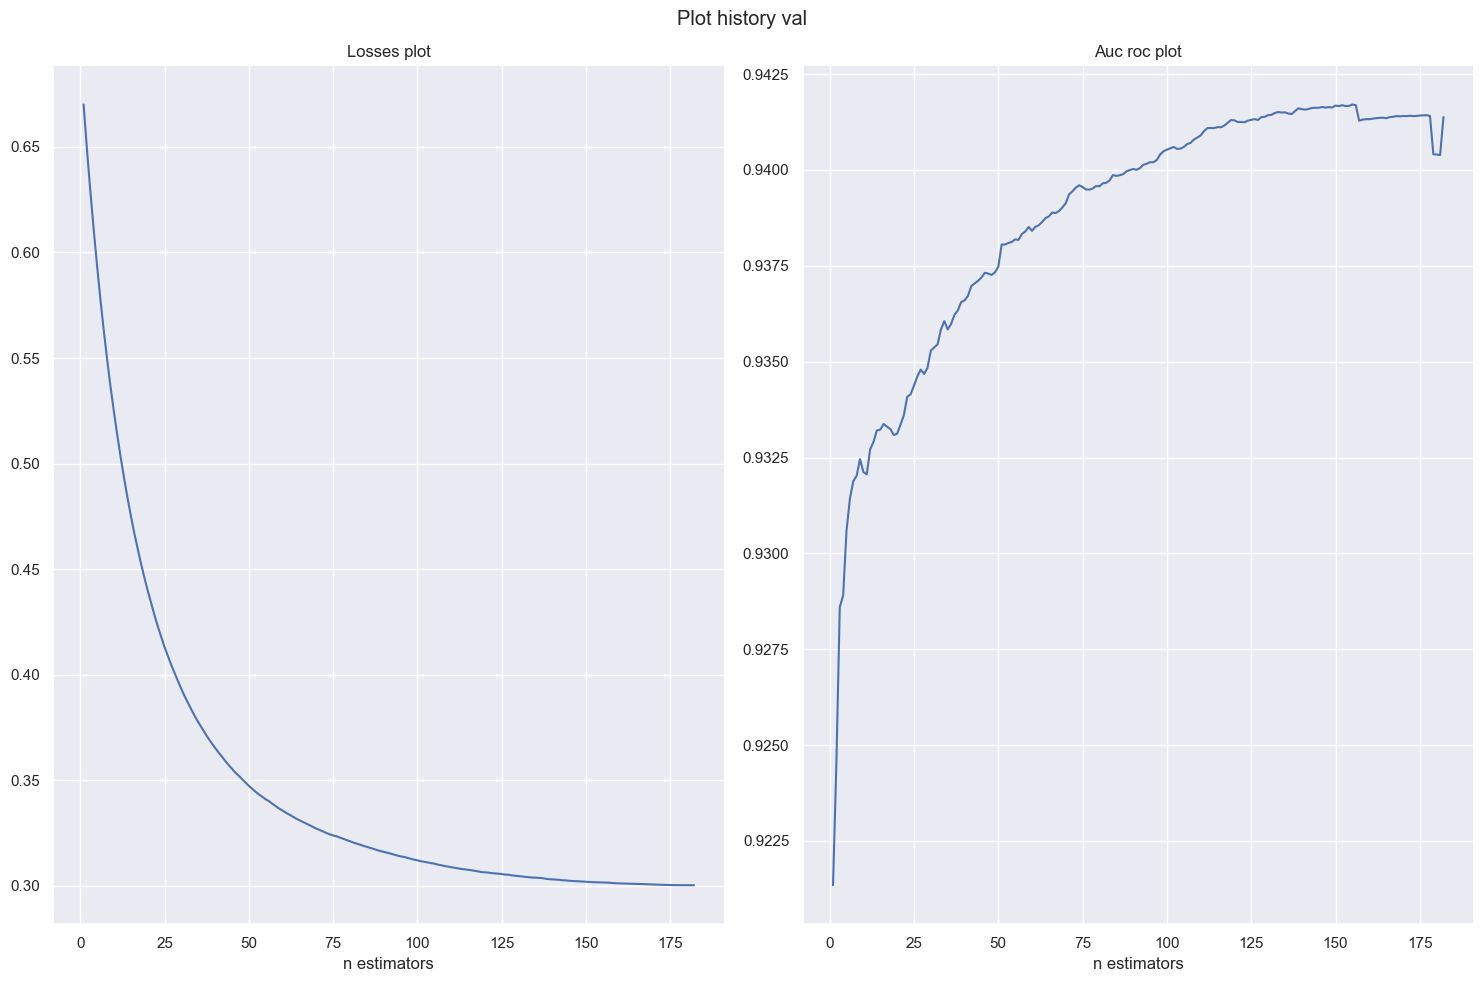

Train ROC-AUC 0.9856
Valid ROC-AUC 0.9414
Test ROC-AUC 0.9380


In [133]:
params = study.best_params.copy()
max_depth = params.pop('max_depth')
boosting = Boosting(base_model_params={'max_depth': max_depth}, **params)

boosting.fit(X_train, y_train, X_valid, y_valid)
boosting.plot_history(X_valid, y_valid, name='val')
print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### 3.2. Глубокая оптимизация (1 балл)

Помимо эффективного перебора гиперпараметров, `optuna` предлагает более тонкий контроль над самой процедурой обучения. Улучшите процедуру оптимизации следующим образом:

1. Посмотрите, как в `optuna` устроена запись в хранилища, и добавьте это в пайплайн оптимизации. Без указания БД все запуски оптуны сотрутся, как только закончится сессия. Более того, так можно распараллелить процесс оптимизации на несколько машин
2. Посмотрите, как можно контролировать процесс обучения бустинга при помощи прунера. У библиотечных имплементаций есть уже готовые, их можно использовать пунктом ниже. Для кастомной модели возьмите что-то из `optuna.pruners`. Идея прунера — не обучать бустинг до конца, если по истории видно, что другие бустинги на этом этапе статистически лучше.
3. Добавьте сохранение истории функции потерь и времени обучения в качестве `user_attribute` сразу в `study`. Мы не хотим оптимизировать их напрямую, но они нам понадобится для сравнения моделей в дальнейшем

Добавьте хранилище и юзер атрибуты и посмотрите, ускорилась ли оптимизация с добавлением прунера

In [136]:
SEED = 42
np.random.seed(SEED)

storage = "sqlite:///optuna_studies.db"

def objective(trial):
    base_params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10)
    }

    boosting_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'early_stopping_rounds': 5,
        'bootstrap_type': 'Bernoulli',
        'base_model_params': base_params
    }

    start_time = time.time()

    model = Boosting(**boosting_params)
    model.fit(X_train, y_train, X_valid, y_valid)

    end_time = time.time()
    
    train_auc = myboost.score(model, X_train, y_train)
    valid_auc = myboost.score(model, X_valid, y_valid)
    test_auc = myboost.score(model, X_test, y_test)

    trial.set_user_attr("train_auc", float(train_auc))
    trial.set_user_attr("valid_auc", float(valid_auc))
    trial.set_user_attr("test_auc", float(test_auc))
    trial.set_user_attr("training_time", end_time - start_time)
    trial.set_user_attr("history", model.history)
    
    return valid_auc

pruner = optuna.pruners.MedianPruner()

opt_study = optuna.create_study(
    direction='maximize',
    storage=storage,
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=pruner,
    load_if_exists=True
)

opt_study.optimize(objective, n_trials=50)

[I 2025-04-08 01:28:22,300] A new study created in RDB with name: no-name-b366cb50-ca42-4d7b-9751-2e0eb650d913


early stopping at iteration 311


[I 2025-04-08 01:28:35,976] Trial 0 finished with value: 0.9423550465225614 and parameters: {'max_depth': 5, 'n_estimators': 478, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183}. Best is trial 0 with value: 0.9423550465225614.
[I 2025-04-08 01:28:40,979] Trial 1 finished with value: 0.9254485633759646 and parameters: {'max_depth': 4, 'n_estimators': 120, 'learning_rate': 0.012184186502221764, 'subsample': 0.9330880728874675}. Best is trial 0 with value: 0.9423550465225614.
[I 2025-04-08 01:29:02,555] Trial 2 finished with value: 0.9375746807435626 and parameters: {'max_depth': 7, 'n_estimators': 369, 'learning_rate': 0.010725209743171997, 'subsample': 0.9849549260809971}. Best is trial 0 with value: 0.9423550465225614.
[I 2025-04-08 01:29:09,549] Trial 3 finished with value: 0.9390325765684652 and parameters: {'max_depth': 9, 'n_estimators': 145, 'learning_rate': 0.01855998084649059, 'subsample': 0.5917022549267169}. Best is trial 0 with value: 0.9423550465225614.

early stopping at iteration 306


[I 2025-04-08 01:30:02,623] Trial 8 finished with value: 0.9425968983894901 and parameters: {'max_depth': 3, 'n_estimators': 477, 'learning_rate': 0.26690431824362526, 'subsample': 0.9041986740582306}. Best is trial 8 with value: 0.9425968983894901.
[I 2025-04-08 01:30:06,905] Trial 9 finished with value: 0.9372845383223462 and parameters: {'max_depth': 5, 'n_estimators': 94, 'learning_rate': 0.1024932221692416, 'subsample': 0.7200762468698007}. Best is trial 8 with value: 0.9425968983894901.


early stopping at iteration 252


[I 2025-04-08 01:30:16,373] Trial 10 finished with value: 0.9417220810754507 and parameters: {'max_depth': 3, 'n_estimators': 263, 'learning_rate': 0.2704729722717779, 'subsample': 0.8548199231905925}. Best is trial 8 with value: 0.9425968983894901.


early stopping at iteration 295


[I 2025-04-08 01:30:27,450] Trial 11 finished with value: 0.94216906802423 and parameters: {'max_depth': 3, 'n_estimators': 459, 'learning_rate': 0.2621521340768057, 'subsample': 0.8389621619162542}. Best is trial 8 with value: 0.9425968983894901.


early stopping at iteration 411


[I 2025-04-08 01:30:44,110] Trial 12 finished with value: 0.9437159621433981 and parameters: {'max_depth': 4, 'n_estimators': 499, 'learning_rate': 0.15444761700714763, 'subsample': 0.8281407226639428}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 423


[I 2025-04-08 01:31:00,537] Trial 13 finished with value: 0.9421543014911007 and parameters: {'max_depth': 3, 'n_estimators': 497, 'learning_rate': 0.1689829465125772, 'subsample': 0.9006772357565654}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:31:08,766] Trial 14 finished with value: 0.9401097352959253 and parameters: {'max_depth': 10, 'n_estimators': 396, 'learning_rate': 0.18078696000505923, 'subsample': 0.9740023822749413}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 115


[I 2025-04-08 01:31:22,746] Trial 15 finished with value: 0.9369385225325323 and parameters: {'max_depth': 4, 'n_estimators': 325, 'learning_rate': 0.04924185908787297, 'subsample': 0.8855067414069814}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 254


[I 2025-04-08 01:31:32,970] Trial 16 finished with value: 0.9421167865150424 and parameters: {'max_depth': 4, 'n_estimators': 449, 'learning_rate': 0.17527265281043325, 'subsample': 0.7957349811641131}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:31:37,750] Trial 17 finished with value: 0.9430247287547501 and parameters: {'max_depth': 6, 'n_estimators': 207, 'learning_rate': 0.29935016322417524, 'subsample': 0.8114854101334926}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 100


[I 2025-04-08 01:31:48,787] Trial 18 finished with value: 0.942100423599953 and parameters: {'max_depth': 8, 'n_estimators': 199, 'learning_rate': 0.07132549138851442, 'subsample': 0.7843813269424708}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:31:56,548] Trial 19 finished with value: 0.942444843007807 and parameters: {'max_depth': 6, 'n_estimators': 186, 'learning_rate': 0.12027515203873773, 'subsample': 0.5260708460957989}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 153


[I 2025-04-08 01:32:04,649] Trial 20 finished with value: 0.9429081928716757 and parameters: {'max_depth': 8, 'n_estimators': 247, 'learning_rate': 0.1991107544618486, 'subsample': 0.7183941017809967}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:32:11,244] Trial 21 finished with value: 0.9427816796013514 and parameters: {'max_depth': 8, 'n_estimators': 231, 'learning_rate': 0.20920323460956383, 'subsample': 0.7154787421327597}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 130
early stopping at iteration 168


[I 2025-04-08 01:32:20,473] Trial 22 finished with value: 0.9426096694451693 and parameters: {'max_depth': 8, 'n_estimators': 312, 'learning_rate': 0.14555476391029834, 'subsample': 0.8342777850893212}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:32:24,952] Trial 23 finished with value: 0.9402558042452587 and parameters: {'max_depth': 9, 'n_estimators': 172, 'learning_rate': 0.28763258396995806, 'subsample': 0.6692932318669765}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 86


[I 2025-04-08 01:32:35,474] Trial 24 finished with value: 0.9417863354493378 and parameters: {'max_depth': 6, 'n_estimators': 233, 'learning_rate': 0.08503441901354593, 'subsample': 0.7481191460266252}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:32:41,665] Trial 25 finished with value: 0.9414243558399243 and parameters: {'max_depth': 9, 'n_estimators': 345, 'learning_rate': 0.21043054472124606, 'subsample': 0.7558856843934306}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 110
early stopping at iteration 164


[I 2025-04-08 01:32:52,189] Trial 26 finished with value: 0.9411054785434291 and parameters: {'max_depth': 10, 'n_estimators': 244, 'learning_rate': 0.13234370734171322, 'subsample': 0.8228603013241699}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 204


[I 2025-04-08 01:33:01,342] Trial 27 finished with value: 0.9428822516648268 and parameters: {'max_depth': 5, 'n_estimators': 285, 'learning_rate': 0.2207109215766394, 'subsample': 0.8644321450414474}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:33:14,118] Trial 28 finished with value: 0.9403767301787229 and parameters: {'max_depth': 8, 'n_estimators': 212, 'learning_rate': 0.03604696968977697, 'subsample': 0.9360005494447706}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:33:21,505] Trial 29 finished with value: 0.9407610591355751 and parameters: {'max_depth': 6, 'n_estimators': 158, 'learning_rate': 0.10366496853297931, 'subsample': 0.7945447220021896}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:33:37,741] Trial 30 finished with value: 0.940118116301215 and parameters: {'max_depth': 4, 'n_estimators': 417, 'learning_rate': 0.06542238287617765, 'subsample': 0.7004831188261247}. Best is trial 12 with value: 0.943715962143

early stopping at iteration 175


[I 2025-04-08 01:33:45,534] Trial 31 finished with value: 0.9427585320629326 and parameters: {'max_depth': 5, 'n_estimators': 286, 'learning_rate': 0.22400126820884536, 'subsample': 0.8677966531210695}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:33:57,625] Trial 32 finished with value: 0.9428371538744589 and parameters: {'max_depth': 5, 'n_estimators': 265, 'learning_rate': 0.15204965824378616, 'subsample': 0.9375112446715791}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 179


[I 2025-04-08 01:34:04,797] Trial 33 finished with value: 0.9426156558775192 and parameters: {'max_depth': 4, 'n_estimators': 360, 'learning_rate': 0.2987138749580855, 'subsample': 0.8258204744036562}. Best is trial 12 with value: 0.9437159621433981.
[I 2025-04-08 01:34:11,149] Trial 34 finished with value: 0.9436086054565933 and parameters: {'max_depth': 7, 'n_estimators': 304, 'learning_rate': 0.21941424890089165, 'subsample': 0.7663867241801678}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 130


[I 2025-04-08 01:34:17,208] Trial 35 finished with value: 0.941929211634751 and parameters: {'max_depth': 7, 'n_estimators': 134, 'learning_rate': 0.12234723811550705, 'subsample': 0.6234370401342368}. Best is trial 12 with value: 0.9437159621433981.


early stopping at iteration 175


[I 2025-04-08 01:34:25,567] Trial 36 finished with value: 0.9438412781272525 and parameters: {'max_depth': 7, 'n_estimators': 321, 'learning_rate': 0.18999347024849259, 'subsample': 0.7349074171376353}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 285


[I 2025-04-08 01:34:39,437] Trial 37 finished with value: 0.9434509627380506 and parameters: {'max_depth': 7, 'n_estimators': 313, 'learning_rate': 0.09983928114486096, 'subsample': 0.7710207099882342}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 295


[I 2025-04-08 01:34:53,718] Trial 38 finished with value: 0.9433344268549759 and parameters: {'max_depth': 7, 'n_estimators': 316, 'learning_rate': 0.10422636722218204, 'subsample': 0.7770073722386651}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 287


[I 2025-04-08 01:35:07,620] Trial 39 finished with value: 0.9429297440281347 and parameters: {'max_depth': 7, 'n_estimators': 386, 'learning_rate': 0.09022413113374084, 'subsample': 0.7414316895920674}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 181


[I 2025-04-08 01:35:15,937] Trial 40 finished with value: 0.9430115586035808 and parameters: {'max_depth': 7, 'n_estimators': 434, 'learning_rate': 0.15390497919813936, 'subsample': 0.6688055595147644}. Best is trial 36 with value: 0.9438412781272525.
[I 2025-04-08 01:35:32,454] Trial 41 finished with value: 0.9424212963738983 and parameters: {'max_depth': 7, 'n_estimators': 333, 'learning_rate': 0.060126374125059924, 'subsample': 0.773455544461032}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 267


[I 2025-04-08 01:35:45,385] Trial 42 finished with value: 0.943806556819624 and parameters: {'max_depth': 7, 'n_estimators': 317, 'learning_rate': 0.10666760906162728, 'subsample': 0.7759567703336973}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 295


[I 2025-04-08 01:35:58,681] Trial 43 finished with value: 0.9437690418435658 and parameters: {'max_depth': 6, 'n_estimators': 372, 'learning_rate': 0.11570106068198444, 'subsample': 0.768967938547498}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 253


[I 2025-04-08 01:36:09,951] Trial 44 finished with value: 0.9425972974849801 and parameters: {'max_depth': 6, 'n_estimators': 372, 'learning_rate': 0.12574595995694623, 'subsample': 0.7390220127108218}. Best is trial 36 with value: 0.9438412781272525.
[I 2025-04-08 01:36:24,540] Trial 45 finished with value: 0.9340917744024941 and parameters: {'max_depth': 5, 'n_estimators': 358, 'learning_rate': 0.013256375202601771, 'subsample': 0.6940042236718942}. Best is trial 36 with value: 0.9438412781272525.
[I 2025-04-08 01:36:29,702] Trial 46 finished with value: 0.9418070884148168 and parameters: {'max_depth': 8, 'n_estimators': 297, 'learning_rate': 0.24210716495043863, 'subsample': 0.626811795010797}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 106
early stopping at iteration 182


[I 2025-04-08 01:36:38,077] Trial 47 finished with value: 0.943008365839661 and parameters: {'max_depth': 6, 'n_estimators': 496, 'learning_rate': 0.18205031838438027, 'subsample': 0.8084460451173445}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 197


[I 2025-04-08 01:36:47,540] Trial 48 finished with value: 0.9435347727909467 and parameters: {'max_depth': 7, 'n_estimators': 343, 'learning_rate': 0.1415657432793407, 'subsample': 0.7344363596950507}. Best is trial 36 with value: 0.9438412781272525.


early stopping at iteration 289


[I 2025-04-08 01:37:04,671] Trial 49 finished with value: 0.9416630149429334 and parameters: {'max_depth': 9, 'n_estimators': 415, 'learning_rate': 0.07755469332622501, 'subsample': 0.8511680173428696}. Best is trial 36 with value: 0.9438412781272525.


In [142]:
print("Лучшие параметры:", opt_study.best_params)
print("Время обучения:", opt_study.best_trial.user_attrs['training_time'])
print("Train AUC-ROC:", opt_study.best_trial.user_attrs['train_auc'])
print("Valid AUC-ROC :", opt_study.best_value)
print("Test AUC-ROC:", opt_study.best_trial.user_attrs['test_auc'])

Лучшие параметры: {'max_depth': 7, 'n_estimators': 321, 'learning_rate': 0.18999347024849259, 'subsample': 0.7349074171376353}
Время обучения: 8.101214170455933
Train AUC-ROC: 0.986459411641297
Valid AUC-ROC : 0.9438412781272525
Test AUC-ROC: 0.940996074776067


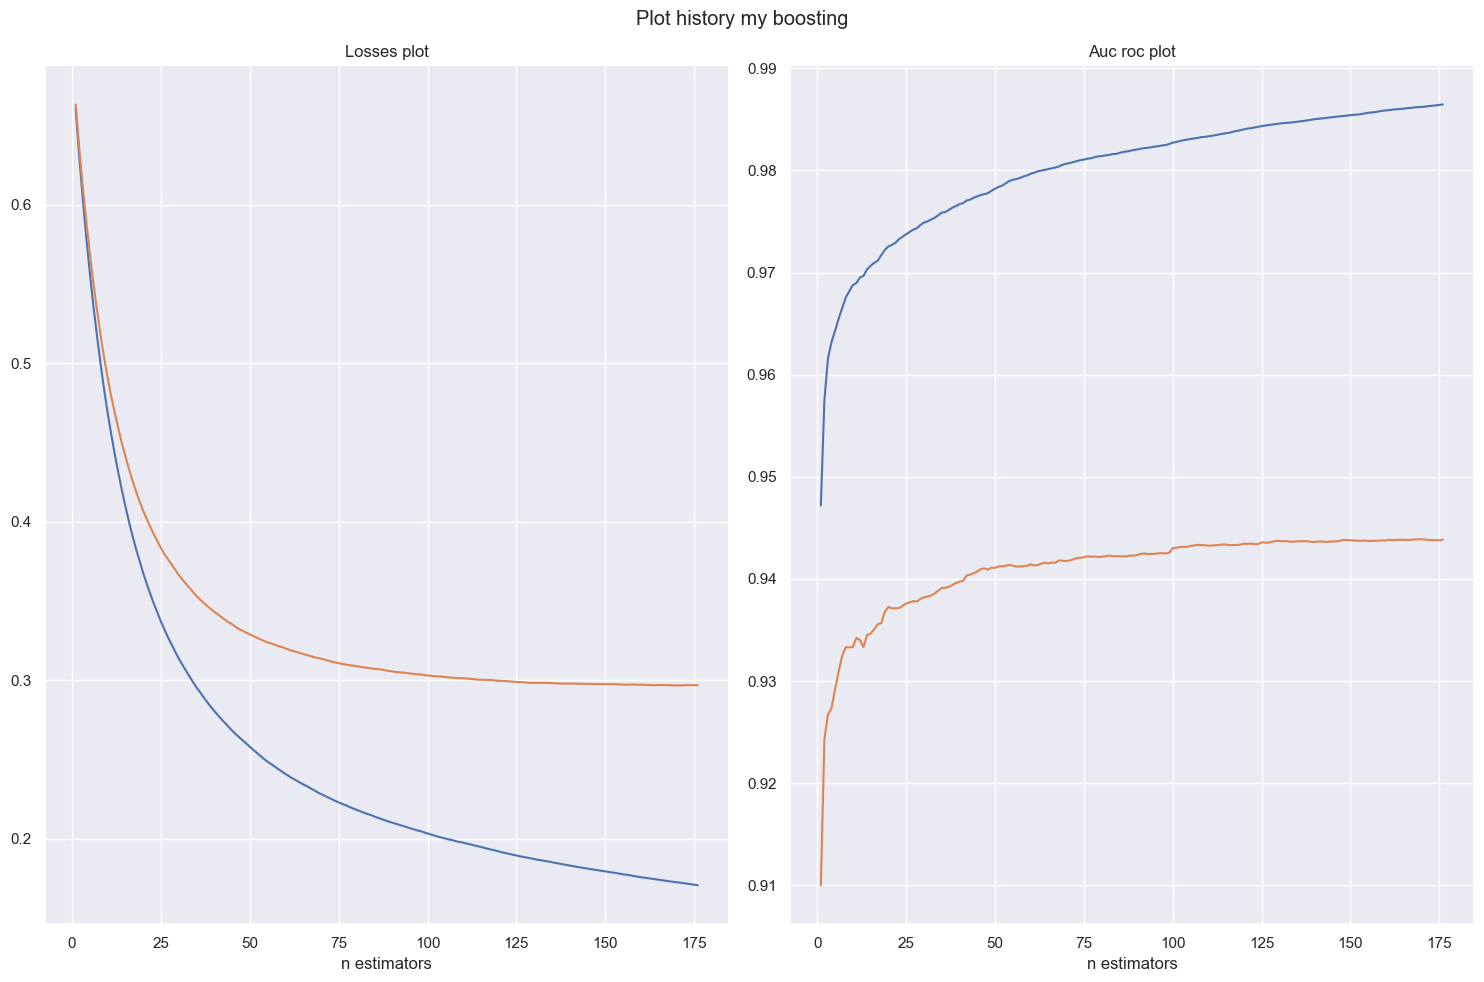

In [144]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 10))
history = opt_study.best_trial.user_attrs['history']
train_auc_roc = history['train_roc_auc']
train_loss = history['train_loss']
val_auc_roc = history['val_roc_auc']
val_loss = history['val_loss']
n_arr = range(1, len(train_auc_roc) + 1)
pred = np.zeros(X.shape[0])

ax[0].plot(n_arr, train_loss, label='Train')
ax[0].plot(n_arr, val_loss, label='Val')
ax[1].plot(n_arr, train_auc_roc, label='Train')
ax[1].plot(n_arr, val_auc_roc, label='Val')

ax[0].set_title('Losses plot')
ax[0].set_xlabel('n estimators')
ax[1].set_title('Auc roc plot')
ax[1].set_xlabel('n estimators')
fig.suptitle(f'Plot history my boosting')
plt.tight_layout()
plt.show()

In [141]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("optuna_studies.db")
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
display(tables)
trials = pd.read_sql_query("SELECT * FROM trials;", conn)
trials.head(5)

,name
0,studies
1,version_info
2,study_directions
3,study_user_attributes
4,study_system_attributes
5,trials
6,trial_user_attributes
7,trial_system_attributes
8,trial_params
9,trial_values


,trial_id,number,study_id,state,datetime_start,datetime_complete
0,1,0,1,COMPLETE,2025-04-08 01:28:22.304398,2025-04-08 01:28:35.969990
1,2,1,1,COMPLETE,2025-04-08 01:28:35.980082,2025-04-08 01:28:40.974713
2,3,2,1,COMPLETE,2025-04-08 01:28:40.982387,2025-04-08 01:29:02.551238
3,4,3,1,COMPLETE,2025-04-08 01:29:02.558942,2025-04-08 01:29:09.545674
4,5,4,1,COMPLETE,2025-04-08 01:29:09.554121,2025-04-08 01:29:22.356718


### 3.3. Готовые реализации (1 балл)

Библиотек для бустингов существует много, но активно используются лишь три. Ваша задача — попробовать их в деле, посмотреть на их уникальные фишки и понять, что вам нравится больше всего

Возьмите любую из популярных библиотек: <font color='lightblue'>`xgboost`</font>, <font color='lightgreen'>`lightgbm`</font>, <font color='palegoldenrod'>`catboost`</font>.
Ваша задача — взять одну из них, подобрать те же оптимальные параметры, что и выше, плюс что-то, что вам понравилось в них больше всего (может быть абсолютно любая фишка из пунктов выше или что-то, что вы найдете сами, не обязательно эксклюзивное), и сравнить две оптимизированные модели по
- динамике функции потерь (на обучающей и на валидационной выборке)
- времени обучения

In [ ]:
from catboost import CatBoostClassifier

SEED = 42
np.random.seed(SEED)

def objective(trial):
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-5, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'eval_metric': 'Logloss',
        'custom_metric': ['AUC'], 
        'random_state': SEED,
        'verbose': False
    }

    start_time = time.time()

    model = CatBoostClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=20,
        plot=False
    )
    
    end_time = time.time()

    evals_result = model.get_evals_result()
    
    trial.set_user_attr("training_time", end_time - start_time)
    trial.set_user_attr("history", evals_result)

    train_auc = myboost.score(model, X_train, y_train)
    valid_auc = myboost.score(model, X_valid, y_valid)
    test_auc = myboost.score(model, X_test, y_test)

    trial.set_user_attr("train_auc", float(train_auc))
    trial.set_user_attr("valid_auc", float(valid_auc))
    trial.set_user_attr("test_auc", float(test_auc))
    
    return valid_auc

cat_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

cat_study.optimize(objective, n_trials=50, n_jobs=1)

[I 2025-04-08 02:19:32,052] A new study created in memory with name: no-name-155ef4e1-7b3f-4ed0-8619-eb7005c1c022
[I 2025-04-08 02:19:32,266] Trial 0 finished with value: 0.9414810273995019 and parameters: {'iterations': 437, 'learning_rate': 0.24517932047070642, 'depth': 9, 'l2_leaf_reg': 0.24810409748678125, 'random_strength': 8.632008168602535e-05, 'bagging_temperature': 0.15599452033620265, 'border_count': 45, 'min_data_in_leaf': 87}. Best is trial 0 with value: 0.9414810273995019.
[I 2025-04-08 02:19:32,801] Trial 1 finished with value: 0.9454432474240381 and parameters: {'iterations': 641, 'learning_rate': 0.09078835431980901, 'depth': 4, 'l2_leaf_reg': 7.579479953348009, 'random_strength': 0.9877700294007907, 'bagging_temperature': 0.21233911067827616, 'border_count': 72, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.9454432474240381.
[I 2025-04-08 02:19:33,415] Trial 2 finished with value: 0.9462685768973199 and parameters: {'iterations': 374, 'learning_rate': 0.042861

In [17]:
print("Лучшие параметры:", cat_study.best_params)
print("Время обучения:", cat_study.best_trial.user_attrs['training_time'])
print("Train AUC-ROC:", cat_study.best_trial.user_attrs['train_auc'])
print("Valid AUC-ROC :", cat_study.best_value)
print("Test AUC-ROC:", cat_study.best_trial.user_attrs['test_auc'])

Лучшие параметры: {'iterations': 162, 'learning_rate': 0.15865000966782158, 'depth': 10, 'l2_leaf_reg': 0.20277656938528535, 'random_strength': 0.1961143449833074, 'bagging_temperature': 0.5387056555788743, 'border_count': 73, 'min_data_in_leaf': 23}
Время обучения: 0.39742517471313477
Train AUC-ROC: 0.9796727245128546
Valid AUC-ROC : 0.9467391104800083
Test AUC-ROC: 0.939499514267315


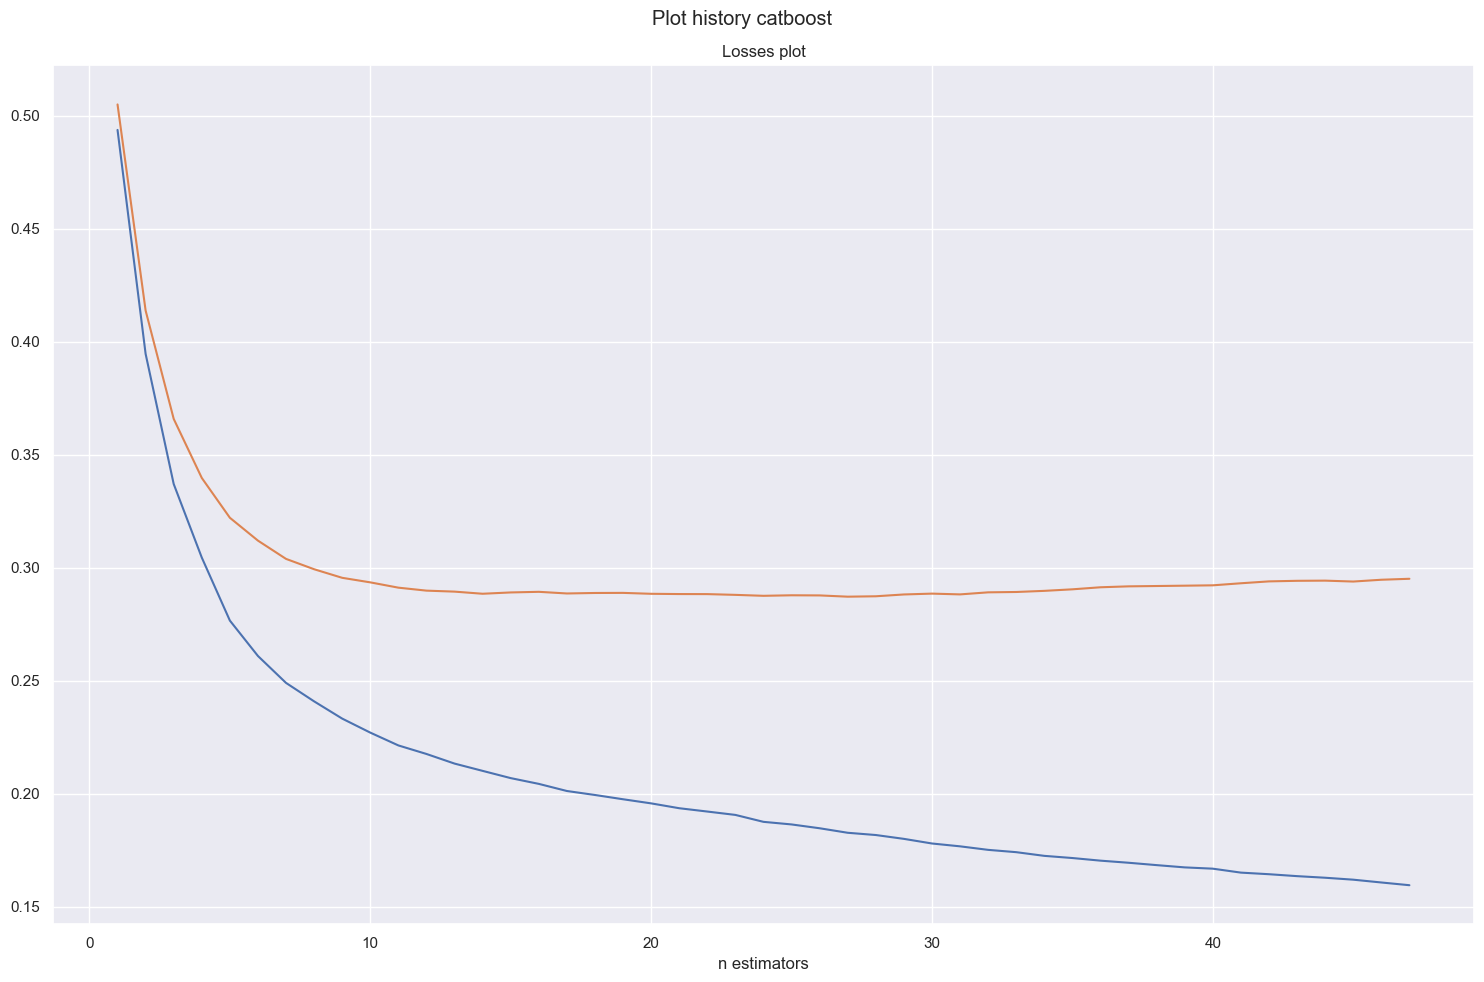

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
history = cat_study.best_trial.user_attrs['history']
train_loss = history['learn']['Logloss']
val_loss = history['validation']['Logloss']
n_arr = range(1, len(train_loss) + 1)
pred = np.zeros(X.shape[0])

ax.plot(n_arr, train_loss, label='Train')
ax.plot(n_arr, val_loss, label='Val')

ax.set_title('Losses plot')
ax.set_xlabel('n estimators')
fig.suptitle(f'Plot history catboost')
plt.tight_layout()
plt.show()

<font color='plum'>**Вопрос:** Какая архитектура вам нравится больше всего и почему?</font>

<font color='plum'>**Ответ**: мне больше всего нравится библиотека catboost из-за современных фичей, совместимости с sklearn и эффективной реализации </font>

### Бонус. Random Forest (0.5 балла)

Если очень захотеть, оптуна может оптимизировать все, что угодно, даже нейросети. Давайте противопоставим бустингу его злейшего врага — алгоритм Random Forest.

Возьмите реализацию случайного леса из <font color='lightgreen'>`lightgbm`</font>. Посмотрите, какие там есть гиперпараметры, переберите что-либо из них вместе с `max_depth` и `n_estimators`.

Сравните его качество и динамику функции потерь (на обучающей и на валидационной выборке) с таковыми у бустинга и сделайте вывод, а нужен ли Random Forest?

In [32]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import time

SEED = 42
np.random.seed(SEED)

def objective(trial):
    start_time = time.time()
    
    y_train_transformed = (y_train == 1).astype(int)
    y_valid_transformed = (y_valid == 1).astype(int)
    
    params = {
        'boosting_type': 'rf',
        'objective': 'binary',
        'metric': 'binary_logloss',
        
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'num_leaves': trial.suggest_int('num_leaves', 31, 511),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        
        'bagging_freq': 1,
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
        
        'random_state': SEED,
        'n_jobs': -1,
        'verbosity': -1
    }

    train_data = lgb.Dataset(X_train, label=y_train_transformed)
    valid_data = lgb.Dataset(X_valid, label=y_valid_transformed, reference=train_data)

    evals_result = {}
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=10, verbose=False),
            lgb.record_evaluation(evals_result)
        ]
    )
    
    trial.set_user_attr("training_time", time.time() - start_time)
    trial.set_user_attr("history", evals_result)
    
    y_pred_proba_train = model.predict(X_train)
    y_pred_proba_val = model.predict(X_valid)
    y_pred_proba_test = model.predict(X_test)
    
    train_auc = roc_auc_score(y_train, y_pred_proba_train)
    val_auc = roc_auc_score(y_valid, y_pred_proba_val)
    test_auc = roc_auc_score(y_test, y_pred_proba_test)

    trial.set_user_attr("train_auc", float(train_auc))
    trial.set_user_attr("valid_auc", float(val_auc))
    trial.set_user_attr("test_auc", float(test_auc))

    return val_auc

rf_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

rf_study.optimize(objective, n_trials=50, n_jobs=1)

[I 2025-04-08 02:38:52,209] A new study created in memory with name: no-name-8f08b65c-0574-4399-9319-eeaa711cd605
[I 2025-04-08 02:38:52,283] Trial 0 finished with value: 0.9319558153401132 and parameters: {'n_estimators': 44, 'num_leaves': 488, 'max_depth': 10, 'min_child_samples': 62, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'reg_alpha': 0.0017073967431528124, 'reg_lambda': 2.9154431891537547, 'bagging_fraction': 0.8005575058716043, 'feature_fraction': 0.8540362888980227, 'extra_trees': False}. Best is trial 0 with value: 0.9319558153401132.
[I 2025-04-08 02:38:52,319] Trial 1 finished with value: 0.9211403275616143 and parameters: {'n_estimators': 85, 'num_leaves': 133, 'max_depth': 4, 'min_child_samples': 22, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119, 'reg_alpha': 0.05342937261279776, 'reg_lambda': 0.014618962793704957, 'bagging_fraction': 0.8059264473611898, 'feature_fraction': 0.569746930326021, 'extra_trees': False}. B

In [33]:
print("Лучшие параметры:", rf_study.best_params)
print("Время обучения:", rf_study.best_trial.user_attrs['training_time'])
print("Train AUC-ROC:", rf_study.best_trial.user_attrs['train_auc'])
print("Valid AUC-ROC :", rf_study.best_value)
print("Test AUC-ROC:", rf_study.best_trial.user_attrs['test_auc'])

Лучшие параметры: {'n_estimators': 36, 'num_leaves': 421, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.6327265169468878, 'colsample_bytree': 0.521193197138299, 'reg_alpha': 0.047176871466039466, 'reg_lambda': 0.077243838476828, 'bagging_fraction': 0.8596073487435095, 'feature_fraction': 0.8230115543704241, 'extra_trees': False}
Время обучения: 0.12125802040100098
Train AUC-ROC: 0.9769359644748785
Valid AUC-ROC : 0.9403252468605153
Test AUC-ROC: 0.9353168598838335


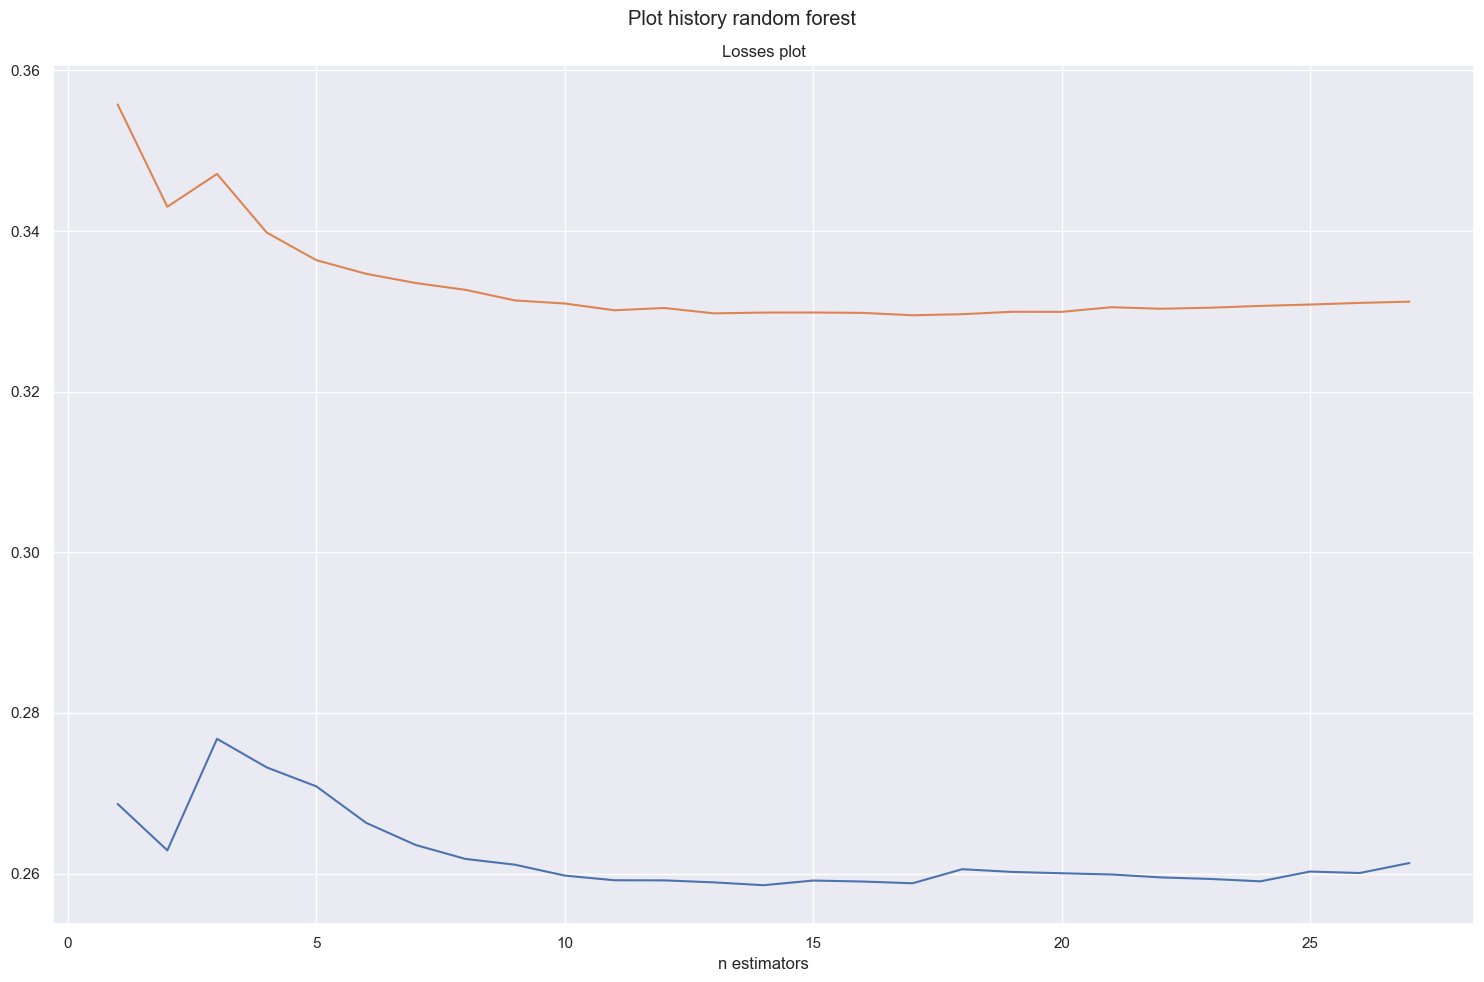

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))
history = rf_study.best_trial.user_attrs['history']
train_loss = history['training']['binary_logloss']
val_loss = history['valid_1']['binary_logloss']
n_arr = range(1, len(train_loss) + 1)
pred = np.zeros(X.shape[0])

ax.plot(n_arr, train_loss, label='Train')
ax.plot(n_arr, val_loss, label='Val')

ax.set_title('Losses plot')
ax.set_xlabel('n estimators')
fig.suptitle(f'Plot history random forest')
plt.tight_layout()
plt.show()

Случайный лес учится гораздо быстрее из-за параллельности обучения, но качесьво показывает хуже

### 3.4. Бустинг и вероятности (0.5 балла)

С качеством мы более-менее разобрались, но что насчет вероятностей? Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности?

In [35]:
from catboost import CatBoostClassifier

SEED = 42
np.random.seed(SEED)

def objective(trial):
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-5, 10, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'eval_metric': 'Logloss',
        'custom_metric': ['AUC'], 
        'random_state': SEED,
        'verbose': False
    }

    start_time = time.time()

    model = CatBoostClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=20,
        plot=False
    )
    
    end_time = time.time()

    evals_result = model.get_evals_result()
    trial.set_user_attr("model", model)
    trial.set_user_attr("training_time", end_time - start_time)
    trial.set_user_attr("history", evals_result)

    train_auc = myboost.score(model, X_train, y_train)
    valid_auc = myboost.score(model, X_valid, y_valid)
    test_auc = myboost.score(model, X_test, y_test)

    trial.set_user_attr("train_auc", float(train_auc))
    trial.set_user_attr("valid_auc", float(valid_auc))
    trial.set_user_attr("test_auc", float(test_auc))
    
    return valid_auc

cat_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

cat_study.optimize(objective, n_trials=50, n_jobs=1)

[I 2025-04-08 02:42:22,507] A new study created in memory with name: no-name-89fc391c-105c-4140-8c55-637d94d76de1
[I 2025-04-08 02:42:22,718] Trial 0 finished with value: 0.9414810273995019 and parameters: {'iterations': 437, 'learning_rate': 0.24517932047070642, 'depth': 9, 'l2_leaf_reg': 0.24810409748678125, 'random_strength': 8.632008168602535e-05, 'bagging_temperature': 0.15599452033620265, 'border_count': 45, 'min_data_in_leaf': 87}. Best is trial 0 with value: 0.9414810273995019.
[I 2025-04-08 02:42:23,205] Trial 1 finished with value: 0.9454432474240381 and parameters: {'iterations': 641, 'learning_rate': 0.09078835431980901, 'depth': 4, 'l2_leaf_reg': 7.579479953348009, 'random_strength': 0.9877700294007907, 'bagging_temperature': 0.21233911067827616, 'border_count': 72, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.9454432474240381.
[I 2025-04-08 02:42:23,762] Trial 2 finished with value: 0.9462685768973199 and parameters: {'iterations': 374, 'learning_rate': 0.042861

In [39]:
def plot_calibration_curve(y_test, preds, model_name='SVM'):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 15
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2) 
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1)) 
    _, ax = plt.subplots(figsize=(8, 8))
    ax.plot(bin_middle_points, bin_real_ratios, label=f'{model_name} calibration curve')
    ax.scatter(bin_middle_points, bin_real_ratios)
    ax.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), label=f'Perfect calibration curve')
    ax.set_ylim([-0.05, 1.05])
    ax.legend()
    plt.show()

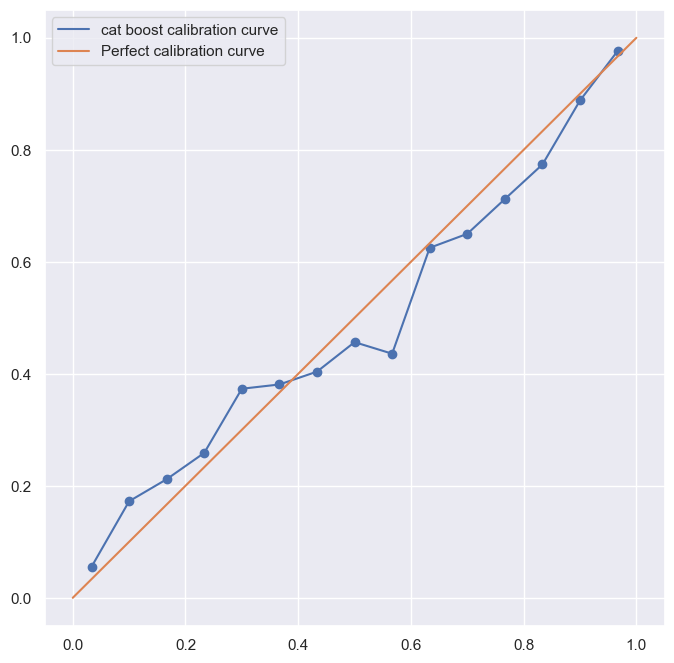

In [40]:
best_boosting = cat_study.best_trial.user_attrs['model']
y_pred_cat = best_boosting.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, y_pred_cat, model_name='cat boost')


Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

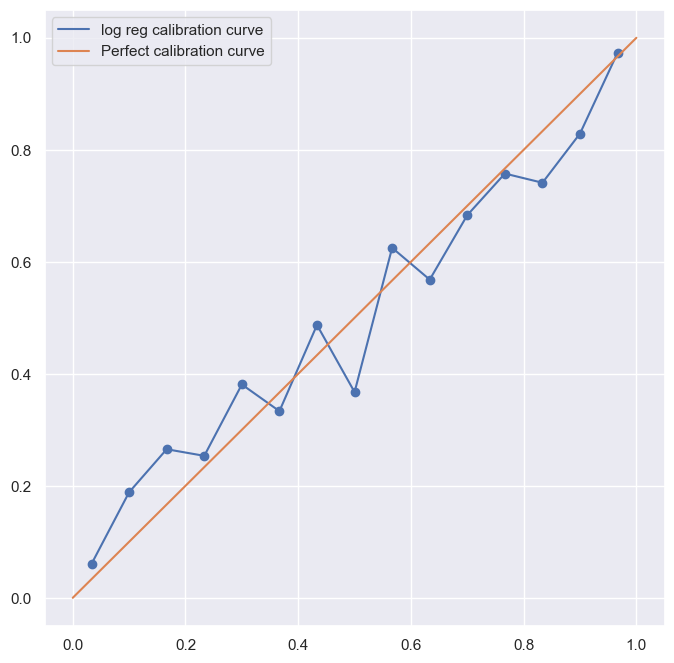

In [41]:
from sklearn.linear_model import LogisticRegression

le = LabelEncoder()
model = LogisticRegression(random_state=42)
model.fit(X_train, le.fit_transform(y_train))
y_pred_log_reg = model.predict_proba(X_test)[:, 1]
plot_calibration_curve(le.transform(y_test), y_pred_log_reg, model_name='log reg')